# Defect Detection Pipeline for Automotive Assemblies
This Python program implements a computer vision pipeline for detecting defects in automotive assemblies using various CNN architectures. The pipeline processes
images from the AutoVI dataset and evaluates model performance.

Note:
 - All measurements are in pixels unless otherwise specified.
 - Australian English is used in all documentation; Syntax may differ in spelling.

## Block 1: Initialisation

In [ ]:
# Standard library imports
import os
import warnings
import logging
from datetime import datetime
from typing import Dict, List, Tuple

# Third-party imports
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torchvision import models, transforms
from torchvision.models import (
    AlexNet_Weights, VGG16_Weights, ResNet50_Weights, EfficientNet_B7_Weights
)
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, precision_recall_fscore_support
)
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from google.colab import drive

In [ ]:
# Configure warnings and logging
warnings.filterwarnings('ignore')
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [ ]:
# Mount Google Drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Set paths
base_path = '/content/gdrive/Shareddrives/Project Group 6: 31256 Image Processing and Pattern Recognition/Assessment Task 2/Implementation/'
dataset_path = os.path.join(base_path, 'AutoVI')

In [ ]:
# Configure plot styling
plt.style.use('seaborn-dark')
sns.set_palette('dark')
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'figure.dpi': 100,
    'figure.autolayout': True,
    'axes.titlesize': 14,
    'axes.labelsize': 12
})

In [ ]:
# Configure hardware
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    logger.info(f'Using GPU: {torch.cuda.get_device_name(0)}')
else:
    logger.warning('GPU not available. Using CPU instead.')

# Configure caching
torch.cuda.empty_cache()

In [ ]:
class AutoVIDataset(Dataset):
    """Custom dataset class for AutoVI automotive assembly images."""

    def __init__(self, image_paths, labels, transform=None, preprocess=None):
        """Initialises the AutoVIDataset.

        Args:
            image_paths: List of paths to image files.
            labels: List of corresponding labels.
            transform: Optional transforms to be applied to images.
            preprocess: Optional preprocessing steps to be applied.
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.preprocess = preprocess

        # Convert labels to numeric
        unique_labels = sorted(set(labels))
        self.label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

    def __len__(self):
        """Returns the total number of images."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """Returns one sample of data.

        Args:
            idx: Index of the sample to fetch.

        Returns:
            tuple: (image, label) where image is the processed image and
                  label is the corresponding class label.
        """
        # Load image
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply preprocessing if specified
        if self.preprocess:
            # We'll only use the bilateral filtered image for training
            filtered, _ = self.preprocess(image)
            image = filtered

        # Convert to PIL Image before transforms
        image = Image.fromarray(image)

        # Apply transforms if specified
        if self.transform:
            image = self.transform(image)

        # Convert label to numeric
        label = torch.tensor(self.label_to_idx[self.labels[idx]])

        return image, label

In [ ]:
def load_dataset():
    """Loads and processes the AutoVI dataset.

    Returns:
        dict: Dictionary containing dataset statistics and splits for each assembly.
    """
    assemblies = [
        'underbody_screw', 'underbody_pipes', 'tank_screw',
        'pipe_staple', 'pipe_clip', 'engine_wiring'
    ]

    dataset_info = {}
    total_images = 0

    for assembly in tqdm(assemblies, desc='Loading assemblies'):
        # Get paths for train and test directories
        train_path = os.path.join(dataset_path, assembly, 'train')
        test_path = os.path.join(dataset_path, assembly, 'test')

        # Initialise lists for paths and labels
        image_paths = []
        labels = []
        class_counts = {}

        # Process train directory (only contains 'good' class)
        for img in os.listdir(os.path.join(train_path, 'good')):
            if img.endswith(('.jpg', '.png')):
                image_paths.append(os.path.join(train_path, 'good', img))
                labels.append('good')
                class_counts['good'] = class_counts.get('good', 0) + 1

        # Process test directory (contains all classes)
        for class_name in os.listdir(test_path):
            class_path = os.path.join(test_path, class_name)
            if os.path.isdir(class_path):
                for img in os.listdir(class_path):
                    if img.endswith(('.jpg', '.png')):
                        image_paths.append(os.path.join(class_path, img))
                        labels.append(class_name)
                        class_counts[class_name] = class_counts.get(class_name, 0) + 1

        # Create DataFrame for class statistics
        stats_df = pd.DataFrame(
            list(class_counts.items()),
            columns=['Class', 'Image Count']
        )
        stats_df.loc[len(stats_df)] = ['Total', stats_df['Image Count'].sum()]

        # Update total image count
        total_images += stats_df.loc[stats_df['Class'] == 'Total', 'Image Count'].values[0]

        # Check if stratification is possible
        min_samples_per_class = min(class_counts.values())

        # Perform train-test split
        try:
            if min_samples_per_class >= 2:
                X_train, X_test, y_train, y_test = train_test_split(
                    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
                )
            else:
                logger.warning(f'Some classes in {assembly} have fewer than 2 samples. '
                             'Performing non-stratified split.')
                X_train, X_test, y_train, y_test = train_test_split(
                    image_paths, labels, test_size=0.2, random_state=42
                )
        except ValueError as e:
            logger.warning(f'Error in stratified split for {assembly}: {str(e)}. '
                         'Performing non-stratified split.')
            X_train, X_test, y_train, y_test = train_test_split(
                image_paths, labels, test_size=0.2, random_state=42
            )

        # Store information
        dataset_info[assembly] = {
            'statistics': stats_df,
            'train_paths': X_train,
            'train_labels': y_train,
            'test_paths': X_test,
            'test_labels': y_test
        }

        # Display statistics
        print(f'\nStatistics for {assembly}:')
        print(stats_df.to_string(index=False))

        # Display split information
        print(f'\nSplit information:')
        print(f'Training samples: {len(X_train)}')
        print(f'Testing samples: {len(X_test)}')

    print(f'\nTotal images in dataset: {total_images:,}')
    return dataset_info

# Load dataset
dataset_info = load_dataset()

Loading assemblies:   0%|          | 0/6 [00:00<?, ?it/s]


Statistics for underbody_screw:
  Class  Image Count
   good          747
missing           18
  Total          765

Split information:
Training samples: 612
Testing samples: 153



Statistics for underbody_pipes:
      Class  Image Count
       good          322
obstruction          180
   multiple            1
   operator            3
      Total          506

Split information:
Training samples: 404
Testing samples: 102

Statistics for tank_screw:
  Class  Image Count
   good          636
missing           95
  Total          731

Split information:
Training samples: 584
Testing samples: 147

Statistics for pipe_staple:
  Class  Image Count
   good          379
missing          117
  Total          496

Split information:
Training samples: 396
Testing samples: 100



Statistics for pipe_clip:
    Class  Image Count
     good          394
unclipped          141
 operator            1
    Total          536

Split information:
Training samples: 428
Testing samples: 108

Statistics for engine_wiring:
      Class  Image Count
       good          574
  fastening          277
   multiple           33
  cardboard            5
  blue_hoop            5
obstruction            2
      Total          896

Split information:
Training samples: 716
Testing samples: 180

Total images in dataset: 3,930


## Block 2: Preprocessing and Augmentation

This block implements bilateral filtering and Canny edge detection for preprocessing, along with class-specific data augmentation to handle class imbalance.

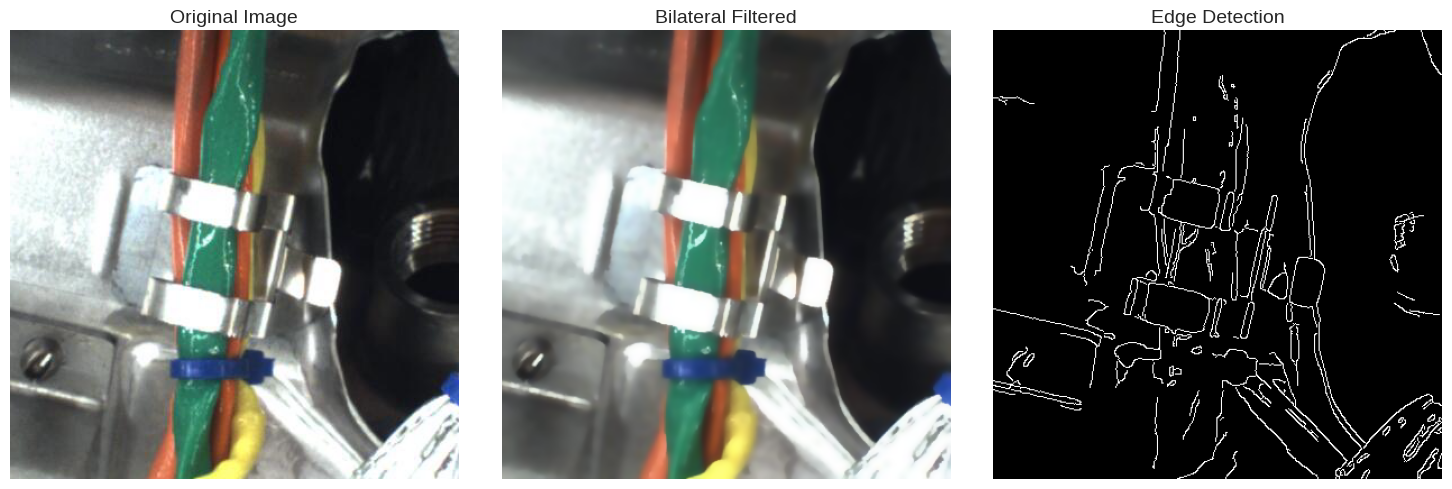

Example shown for assembly: engine_wiring
Image path: /content/gdrive/Shareddrives/Project Group 6: 31256 Image Processing and Pattern Recognition/Assessment Task 2/Implementation/AutoVI/engine_wiring/test/blue_hoop/0002.png


In [ ]:
class ImagePreprocessor:
    """Handles image preprocessing operations for the AutoVI dataset.

    Attributes:
        bilateral_d (int): Diameter of pixel neighbourhood for bilateral filter.
        bilateral_sigma_color (float): Filter sigma in the color space.
        bilateral_sigma_space (float): Filter sigma in the coordinate space.
        canny_low (int): Lower threshold for Canny edge detection.
        canny_high (int): Upper threshold for Canny edge detection.
    """

    def __init__(
        self,
        bilateral_d=9,
        bilateral_sigma_color=75.0,
        bilateral_sigma_space=75.0,
        canny_low=50,
        canny_high=150
    ):
        """Initialises the ImagePreprocessor with specified parameters."""
        self.bilateral_d = bilateral_d
        self.bilateral_sigma_color = bilateral_sigma_color
        self.bilateral_sigma_space = bilateral_sigma_space
        self.canny_low = canny_low
        self.canny_high = canny_high

    def preprocess(self, image):
        """Applies preprocessing steps to an image.

        Args:
            image: Input image in RGB format.

        Returns:
            tuple: (filtered_image, edges) containing the bilateral filtered image
                  and the edge detection result.
        """
        # Apply bilateral filter
        filtered = cv2.bilateralFilter(
            image,
            self.bilateral_d,
            self.bilateral_sigma_color,
            self.bilateral_sigma_space
        )

        # Convert to grayscale for edge detection
        gray = cv2.cvtColor(filtered, cv2.COLOR_RGB2GRAY)

        # Apply Canny edge detection
        edges = cv2.Canny(gray, self.canny_low, self.canny_high)

        # Stack edges to create 3-channel image
        edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

        return filtered, edges_rgb

# Create data augmentation transforms
def create_augmentation_transforms(is_defect=False):
    """Creates augmentation transforms based on class type.

    Args:
        is_defect: Boolean indicating if transforms are for defect class.

    Returns:
        torchvision.transforms.Compose: Composed transformation pipeline.
    """
    base_transforms = [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]

    if is_defect:
        # More aggressive augmentation for defect classes
        augmentation_transforms = [
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(20),
            transforms.ColorJitter(
                brightness=0.2,
                contrast=0.2,
                saturation=0.2
            ),
            transforms.RandomAffine(
                degrees=0,
                translate=(0.1, 0.1),
                scale=(0.9, 1.1)
            )
        ]
        return transforms.Compose(augmentation_transforms + base_transforms)
    else:
        # Less aggressive augmentation for 'good' class
        augmentation_transforms = [
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.1)
        ]
        return transforms.Compose(augmentation_transforms + base_transforms)

# Display preprocessing example
def show_preprocessing_example(dataset_info):
    """Shows preprocessing steps for a random image from the dataset.

    Args:
        dataset_info: Dictionary containing dataset information.
    """
    # Select random assembly and image
    assembly = np.random.choice(list(dataset_info.keys()))
    img_path = np.random.choice(dataset_info[assembly]['train_paths'])

    # Load and process image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create preprocessor and apply
    preprocessor = ImagePreprocessor()
    filtered, edges = preprocessor.preprocess(image)

    # Create figure
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Bilateral filtered
    plt.subplot(1, 3, 2)
    plt.imshow(filtered)
    plt.title('Bilateral Filtered')
    plt.axis('off')

    # Edge detection
    plt.subplot(1, 3, 3)
    plt.imshow(edges, cmap='gray')
    plt.title('Edge Detection')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f'Example shown for assembly: {assembly}')
    print(f'Image path: {img_path}')

# Show preprocessing example
show_preprocessing_example(dataset_info)

## Block 3: Training

This block implements the training pipeline for multiple CNN architectures,
including model setup, training utilities, and progress tracking.

In [ ]:
class EarlyStopping:
    """Implements early stopping to prevent overfitting."""

    def __init__(self, patience=2, min_epochs=2, min_delta=1e-4):
        """Initialises early stopping with specified parameters."""
        self.patience = patience
        self.min_epochs = min_epochs
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, epoch, val_loss):
        """Determines if training should stop."""
        if epoch < self.min_epochs:
            return False

        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

        return self.early_stop

def get_batch_size(model_name):
    """Determines batch size for speed-optimized training."""
    if not torch.cuda.is_available():
        return 4

    if model_name == 'resnet50':
        return 64
    elif model_name == 'vgg16':
        return 48
    else:  # alexnet
        return 96

def train_model(
    model_name,
    train_loader,
    val_loader,
    num_classes,
    device,
    max_epochs=15,  # Increased from 6
    learning_rate=0.0001,  # Reduced from 0.003
    save_path=None
):
    """Trains a model with optimizations for class imbalance and better learning."""
    # Setup model
    if model_name == 'alexnet':
        model = models.alexnet(weights=AlexNet_Weights.DEFAULT)
        model.classifier[6] = nn.Linear(4096, num_classes)
    elif model_name == 'vgg16':
        model = models.vgg16(weights=VGG16_Weights.DEFAULT)
        model.classifier[6] = nn.Linear(4096, num_classes)
    elif model_name == 'resnet50':
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        model.fc = nn.Linear(2048, num_classes)

    model = model.to(device)

    # Calculate class weights to handle imbalance
    all_labels = []
    for _, labels in train_loader:
        all_labels.extend(labels.numpy())
    class_counts = np.bincount(all_labels)
    total_samples = len(all_labels)
    class_weights = torch.FloatTensor([total_samples / (len(class_counts) * count) for count in class_counts]).to(device)

    print(f"Class weights: {class_weights.cpu().numpy()}")

    # Setup training utilities with class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Optimizer with weight decay to prevent overfitting
    optimiser = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=0.01,
        amsgrad=True
    )

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimiser,
        mode='min',
        factor=0.5,
        patience=2,
        verbose=True
    )

    # More patient early stopping
    early_stopping = EarlyStopping(patience=4, min_epochs=8)
    tracker = TrainingTracker()

    # Enable gradient scaler for mixed precision training
    scaler = GradScaler()

    best_val_loss = float('inf')
    best_model_state = None

    # Training loop
    for epoch in range(max_epochs):
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_bar = tqdm(
            train_loader,
            desc=f'Epoch {epoch + 1}/{max_epochs} [Training]'
        )

        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            optimiser.zero_grad()

            # Mixed precision training
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimiser)
            scaler.update()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Show per-class accuracy in progress bar
            accuracies = {}
            for i in range(num_classes):
                mask = labels == i
                if mask.sum().item() > 0:
                    class_acc = (predicted[mask] == labels[mask]).float().mean().item()
                    accuracies[f'cls{i}'] = f'{class_acc:.2f}'

            train_bar.set_postfix({
                'loss': f'{train_loss/len(train_loader):.4f}',
                'acc': f'{100.*train_correct/train_total:.2f}%',
                **accuracies
            })

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_class_correct = np.zeros(num_classes)
        val_class_total = np.zeros(num_classes)

        with torch.no_grad():
            val_bar = tqdm(
                val_loader,
                desc=f'Epoch {epoch + 1}/{max_epochs} [Validation]'
            )

            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)

                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                # Per-class accuracy
                for i in range(num_classes):
                    mask = labels == i
                    val_class_total[i] += mask.sum().item()
                    val_class_correct[i] += (predicted[mask] == labels[mask]).sum().item()

                val_bar.set_postfix({
                    'loss': f'{val_loss/len(val_loader):.4f}',
                    'acc': f'{100.*val_correct/val_total:.2f}%'
                })

        # Calculate and log metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_train_acc = train_correct / train_total
        epoch_val_acc = val_correct / val_total

        # Print per-class validation accuracies
        print("\nPer-class validation accuracies:")
        for i in range(num_classes):
            if val_class_total[i] > 0:
                class_acc = val_class_correct[i] / val_class_total[i]
                print(f"Class {i}: {class_acc:.4f}")

        tracker.update(
            epoch_train_loss,
            epoch_val_loss,
            epoch_train_acc,
            epoch_val_acc
        )

        # Update learning rate based on validation loss
        scheduler.step(epoch_val_loss)

        # Save best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()

        # Check for early stopping
        if early_stopping(epoch, epoch_val_loss):
            print(f'\nEarly stopping triggered after epoch {epoch + 1}')
            break

    # Load and save best model
    model.load_state_dict(best_model_state)
    if save_path:
        torch.save(best_model_state, save_path)
        print(f'\nBest model saved to {save_path}')

    return model, tracker

# Create output directory for models
models_dir = os.path.join(base_path, 'models')
os.makedirs(models_dir, exist_ok=True)

In [ ]:
class TrainingTracker:
    """Tracks and stores training metrics."""

    def __init__(self):
        """Initializes empty lists for tracking metrics."""
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []

    def update(self, train_loss, val_loss, train_acc, val_acc):
        """Updates tracking metrics.

        Args:
            train_loss (float): Training loss for current epoch.
            val_loss (float): Validation loss for current epoch.
            train_acc (float): Training accuracy for current epoch.
            val_acc (float): Validation accuracy for current epoch.
        """
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_accs.append(train_acc)
        self.val_accs.append(val_acc)

    def plot_metrics(self, save_path=None):
        """Plots training metrics.

        Args:
            save_path (str, optional): Path to save plot to.
        """
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.title('Loss vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.train_accs, label='Training Accuracy')
        plt.plot(self.val_accs, label='Validation Accuracy')
        plt.title('Accuracy vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
            plt.close()
        else:
            plt.show()

In [ ]:
# Train models for each assembly
for assembly in dataset_info:
    print(f'\nTraining models for {assembly}...')

    assembly_dir = os.path.join(models_dir, assembly)
    os.makedirs(assembly_dir, exist_ok=True)

    unique_labels = sorted(set(
        dataset_info[assembly]['train_labels'] +
        dataset_info[assembly]['test_labels']
    ))
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

    print(f'Classes for {assembly}: {unique_labels}')

    architectures = ['alexnet', 'vgg16', 'resnet50']

    for arch in architectures:
        print(f'\nTraining {arch} for {assembly}...')

        batch_size = get_batch_size(arch)
        print(f'Using batch size: {batch_size}')

        # Setup datasets
        train_dataset = AutoVIDataset(
            dataset_info[assembly]['train_paths'],
            [label_to_idx[label] for label in dataset_info[assembly]['train_labels']],
            transform=transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
            preprocess=ImagePreprocessor().preprocess
        )

        val_dataset = AutoVIDataset(
            dataset_info[assembly]['test_paths'],
            [label_to_idx[label] for label in dataset_info[assembly]['test_labels']],
            transform=transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
            preprocess=ImagePreprocessor().preprocess
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,  # Increased workers
            pin_memory=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size * 2,  # Larger validation batch size
            shuffle=False,
            num_workers=4,  # Increased workers
            pin_memory=True
        )

        # Clear cache before training
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        try:
            model, tracker = train_model(
                arch,
                train_loader,
                val_loader,
                len(unique_labels),
                device,
                save_path=os.path.join(assembly_dir, f'{arch}.pth')
            )

            tracker.plot_metrics(
                save_path=os.path.join(assembly_dir, f'{arch}_training_history.png')
            )

        except RuntimeError as e:
            print(f"Error training {arch}: {str(e)}")
            print("Skipping to next model...")
            continue

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        del model
        del tracker

print('\nTraining completed for all models!')


Training models for underbody_screw...
Classes for underbody_screw: ['good', 'missing']

Training alexnet for underbody_screw...
Using batch size: 96
Class weights: [ 0.5117057 21.857143 ]


Epoch 1/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 2/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.5638
Class 1: 1.0000


Epoch 3/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.7500


Epoch 4/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.7517
Class 1: 1.0000


Epoch 5/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.9933
Class 1: 1.0000


Epoch 6/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.9463
Class 1: 1.0000


Epoch 7/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 8/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 9/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 10/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 11/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 12/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 13/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 14/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 15/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000

Early stopping triggered after epoch 15

Best model saved to /content/gdrive/Shareddrives/Project Group 6: 31256 Image Processing and Pattern Recognition/Assessment Task 2/Implementation/models/underbody_screw/alexnet.pth

Training vgg16 for underbody_screw...
Using batch size: 48


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 208MB/s]


Class weights: [ 0.5117057 21.857143 ]


Epoch 1/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 2/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 3/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 4/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 5/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.9732
Class 1: 1.0000


Epoch 6/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.8792
Class 1: 1.0000


Epoch 7/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.9933
Class 1: 1.0000


Epoch 8/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 9/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 10/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.8591
Class 1: 1.0000


Epoch 11/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 12/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 13/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000

Early stopping triggered after epoch 13

Best model saved to /content/gdrive/Shareddrives/Project Group 6: 31256 Image Processing and Pattern Recognition/Assessment Task 2/Implementation/models/underbody_screw/vgg16.pth

Training resnet50 for underbody_screw...
Using batch size: 64


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 225MB/s]


Class weights: [ 0.5117057 21.857143 ]


Epoch 1/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 2/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.9933
Class 1: 0.0000


Epoch 3/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.9866
Class 1: 0.7500


Epoch 4/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.7500


Epoch 5/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.7500


Epoch 6/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.7500


Epoch 7/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.7500


Epoch 8/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.7500


Epoch 9/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 10/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 11/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 12/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 13/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 14/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 15/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000

Early stopping triggered after epoch 15

Best model saved to /content/gdrive/Shareddrives/Project Group 6: 31256 Image Processing and Pattern Recognition/Assessment Task 2/Implementation/models/underbody_screw/resnet50.pth

Training models for underbody_pipes...
Classes for underbody_pipes: ['good', 'multiple', 'obstruction', 'operator']

Training alexnet for underbody_pipes...
Using batch size: 96
Class weights: [  0.38403043 101.           0.73722625  33.666668  ]


Epoch 1/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.1356
Class 1: 0.0000


Epoch 2/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.2712
Class 1: 0.0000


Epoch 3/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 4/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.8983
Class 1: 0.0000


Epoch 5/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 6/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 7/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 8/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 9/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 10/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 11/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 12/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 13/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000

Early stopping triggered after epoch 13

Best model saved to /content/gdrive/Shareddrives/Project Group 6: 31256 Image Processing and Pattern Recognition/Assessment Task 2/Implementation/models/underbody_pipes/alexnet.pth

Training vgg16 for underbody_pipes...
Using batch size: 48
Class weights: [  0.38403043 101.           0.73722625  33.666668  ]


Epoch 1/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.8136
Class 1: 0.0000


Epoch 2/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 3/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 4/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 5/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 6/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 7/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 8/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 9/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 10/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 11/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 12/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 13/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000

Early stopping triggered after epoch 13

Best model saved to /content/gdrive/Shareddrives/Project Group 6: 31256 Image Processing and Pattern Recognition/Assessment Task 2/Implementation/models/underbody_pipes/vgg16.pth

Training resnet50 for underbody_pipes...
Using batch size: 64
Class weights: [  0.38403043 101.           0.73722625  33.666668  ]


Epoch 1/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 2/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 3/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 4/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 5/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 6/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 7/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 8/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 9/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 10/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 11/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 12/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 13/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 14/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 15/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000

Early stopping triggered after epoch 15

Best model saved to /content/gdrive/Shareddrives/Project Group 6: 31256 Image Processing and Pattern Recognition/Assessment Task 2/Implementation/models/underbody_pipes/resnet50.pth

Training models for tank_screw...
Classes for tank_screw: ['good', 'missing']

Training alexnet for tank_screw...
Using batch size: 96
Class weights: [0.5748032 3.8421052]


Epoch 1/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 2/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.4737


Epoch 3/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.9141
Class 1: 1.0000


Epoch 4/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 5/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 6/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 7/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 8/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.9844
Class 1: 1.0000


Epoch 9/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 10/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 11/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 12/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 13/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 14/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 15/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000

Best model saved to /content/gdrive/Shareddrives/Project Group 6: 31256 Image Processing and Pattern Recognition/Assessment Task 2/Implementation/models/tank_screw/alexnet.pth

Training vgg16 for tank_screw...
Using batch size: 48
Class weights: [0.5748032 3.8421052]


Epoch 1/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.9609
Class 1: 0.5263


Epoch 2/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 3/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.9922
Class 1: 1.0000


Epoch 4/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 5/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 6/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 7/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 8/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 9/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 10/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 11/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 12/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 13/15 [Training]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000

Early stopping triggered after epoch 13

Best model saved to /content/gdrive/Shareddrives/Project Group 6: 31256 Image Processing and Pattern Recognition/Assessment Task 2/Implementation/models/tank_screw/vgg16.pth

Training resnet50 for tank_screw...
Using batch size: 64
Class weights: [0.5748032 3.8421052]


Epoch 1/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.0000


Epoch 2/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.1053


Epoch 3/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.5789


Epoch 4/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 5/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.9474


Epoch 6/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 7/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 8/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 9/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 10/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 11/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 12/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 13/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 14/15 [Training]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000

Early stopping triggered after epoch 14

Best model saved to /content/gdrive/Shareddrives/Project Group 6: 31256 Image Processing and Pattern Recognition/Assessment Task 2/Implementation/models/tank_screw/resnet50.pth

Training models for pipe_staple...
Classes for pipe_staple: ['good', 'missing']

Training alexnet for pipe_staple...
Using batch size: 96
Class weights: [0.65346533 2.1290324 ]


Epoch 1/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.9342
Class 1: 0.5417


Epoch 2/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.5833


Epoch 3/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.9167


Epoch 4/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.9583


Epoch 5/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.9583


Epoch 6/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.9583


Epoch 7/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.9583


Epoch 8/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.9583


Epoch 9/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.9583


Epoch 10/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.9583


Epoch 11/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.9583


Epoch 12/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.9583


Epoch 13/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.9583


Epoch 14/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.9583


Epoch 15/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.9583

Best model saved to /content/gdrive/Shareddrives/Project Group 6: 31256 Image Processing and Pattern Recognition/Assessment Task 2/Implementation/models/pipe_staple/alexnet.pth

Training vgg16 for pipe_staple...
Using batch size: 48
Class weights: [0.65346533 2.1290324 ]


Epoch 1/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.8333


Epoch 2/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 3/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 4/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 5/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 6/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 7/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 8/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 9/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 10/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 11/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 12/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 13/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000

Early stopping triggered after epoch 13

Best model saved to /content/gdrive/Shareddrives/Project Group 6: 31256 Image Processing and Pattern Recognition/Assessment Task 2/Implementation/models/pipe_staple/vgg16.pth

Training resnet50 for pipe_staple...
Using batch size: 64
Class weights: [0.65346533 2.1290324 ]


Epoch 1/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.2083


Epoch 2/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.5833


Epoch 3/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.7500


Epoch 4/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.9583


Epoch 5/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 0.9583


Epoch 6/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 7/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 8/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 9/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 10/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 11/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 12/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 13/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 14/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000


Epoch 15/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000

Best model saved to /content/gdrive/Shareddrives/Project Group 6: 31256 Image Processing and Pattern Recognition/Assessment Task 2/Implementation/models/pipe_staple/resnet50.pth

Training models for pipe_clip...
Classes for pipe_clip: ['good', 'operator', 'unclipped']

Training alexnet for pipe_clip...
Using batch size: 96
Class weights: [0.672956  1.9454546]


Epoch 1/15 [Training]:   0%|          | 0/5 [00:00<?, ?it/s]

Error training alexnet: weight tensor should be defined either for all 3 classes or no classes but got weight tensor of shape: [2]
Skipping to next model...

Training vgg16 for pipe_clip...
Using batch size: 48
Class weights: [0.672956  1.9454546]


Epoch 1/15 [Training]:   0%|          | 0/9 [00:00<?, ?it/s]

Error training vgg16: weight tensor should be defined either for all 3 classes or no classes but got weight tensor of shape: [2]
Skipping to next model...

Training resnet50 for pipe_clip...
Using batch size: 64
Class weights: [0.672956  1.9454546]


Epoch 1/15 [Training]:   0%|          | 0/7 [00:00<?, ?it/s]

Error training resnet50: weight tensor should be defined either for all 3 classes or no classes but got weight tensor of shape: [2]
Skipping to next model...

Training models for engine_wiring...
Classes for engine_wiring: ['blue_hoop', 'cardboard', 'fastening', 'good', 'multiple', 'obstruction']

Training alexnet for engine_wiring...
Using batch size: 96
Class weights: [29.833334   29.833334    0.53996986  0.25998548  4.5897436  59.666668  ]


Epoch 1/15 [Training]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 0.0000
Class 2: 0.4107
Class 3: 0.2783
Class 4: 1.0000


Epoch 2/15 [Training]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 0.0000
Class 2: 0.6607
Class 3: 0.7565
Class 4: 0.7143


Epoch 3/15 [Training]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.6964
Class 3: 0.8957
Class 4: 0.7143


Epoch 4/15 [Training]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000
Class 2: 0.7143
Class 3: 0.6348
Class 4: 0.5714


Epoch 5/15 [Training]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.6429
Class 3: 0.9217
Class 4: 0.7143


Epoch 6/15 [Training]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000
Class 2: 0.7321
Class 3: 0.8348
Class 4: 0.5714


Epoch 7/15 [Training]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.7321
Class 3: 0.9391
Class 4: 0.5714


Epoch 8/15 [Training]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.7321
Class 3: 0.9130
Class 4: 0.7143


Epoch 9/15 [Training]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.6607
Class 3: 0.9652
Class 4: 0.5714


Epoch 10/15 [Training]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.9643
Class 3: 0.5130
Class 4: 0.4286


Epoch 11/15 [Training]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.6786
Class 3: 0.9565
Class 4: 0.5714


Epoch 12/15 [Training]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.7679
Class 3: 0.9217
Class 4: 0.5714


Epoch 13/15 [Training]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.7500
Class 3: 0.9565
Class 4: 0.5714


Epoch 14/15 [Training]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.8036
Class 3: 0.9217
Class 4: 0.7143


Epoch 15/15 [Training]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15/15 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.7679
Class 3: 0.9391
Class 4: 0.7143

Early stopping triggered after epoch 15

Best model saved to /content/gdrive/Shareddrives/Project Group 6: 31256 Image Processing and Pattern Recognition/Assessment Task 2/Implementation/models/engine_wiring/alexnet.pth

Training vgg16 for engine_wiring...
Using batch size: 48
Class weights: [29.833334   29.833334    0.53996986  0.25998548  4.5897436  59.666668  ]


Epoch 1/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 0.0000
Class 2: 1.0000
Class 3: 0.0000
Class 4: 0.0000


Epoch 2/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 0.0000
Class 2: 0.7321
Class 3: 0.8348
Class 4: 0.0000


Epoch 3/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 0.0000
Class 2: 0.4643
Class 3: 0.9043
Class 4: 0.0000


Epoch 4/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 0.0000
Class 2: 0.0536
Class 3: 0.0000
Class 4: 1.0000


Epoch 5/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.1250
Class 3: 0.9565
Class 4: 0.1429


Epoch 6/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.4464
Class 3: 0.8087
Class 4: 0.8571


Epoch 7/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.6071
Class 3: 0.9043
Class 4: 0.8571


Epoch 8/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.0536
Class 3: 1.0000
Class 4: 0.5714


Epoch 9/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.8393
Class 3: 0.6348
Class 4: 0.7143


Epoch 10/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.8571
Class 3: 0.9565
Class 4: 0.7143


Epoch 11/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000
Class 2: 0.3393
Class 3: 0.7913
Class 4: 0.7143


Epoch 12/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 1.0000
Class 1: 1.0000
Class 2: 0.4821
Class 3: 0.9826
Class 4: 0.7143


Epoch 13/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.8214
Class 3: 0.8696
Class 4: 0.8571


Epoch 14/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.9821
Class 3: 0.7217
Class 4: 0.4286


Epoch 15/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.8036
Class 3: 0.9565
Class 4: 0.8571

Best model saved to /content/gdrive/Shareddrives/Project Group 6: 31256 Image Processing and Pattern Recognition/Assessment Task 2/Implementation/models/engine_wiring/vgg16.pth

Training resnet50 for engine_wiring...
Using batch size: 64
Class weights: [29.833334   29.833334    0.53996986  0.25998548  4.5897436  59.666668  ]


Epoch 1/15 [Training]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 0.0000
Class 2: 0.6250
Class 3: 0.5739
Class 4: 0.0000


Epoch 2/15 [Training]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 0.0000
Class 2: 0.7679
Class 3: 0.7652
Class 4: 0.0000


Epoch 3/15 [Training]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.8036
Class 3: 0.8609
Class 4: 0.2857


Epoch 4/15 [Training]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.7857
Class 3: 0.8870
Class 4: 0.2857


Epoch 5/15 [Training]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.7679
Class 3: 0.9217
Class 4: 0.2857


Epoch 6/15 [Training]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.8393
Class 3: 0.9217
Class 4: 0.2857


Epoch 7/15 [Training]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.8214
Class 3: 0.9565
Class 4: 0.4286


Epoch 8/15 [Training]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.8393
Class 3: 0.9478
Class 4: 0.5714


Epoch 9/15 [Training]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.7857
Class 3: 0.9652
Class 4: 0.5714


Epoch 10/15 [Training]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.7679
Class 3: 0.9913
Class 4: 0.4286


Epoch 11/15 [Training]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 11/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.7679
Class 3: 0.9913
Class 4: 0.4286


Epoch 12/15 [Training]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 12/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.8036
Class 3: 0.9739
Class 4: 0.7143


Epoch 13/15 [Training]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 13/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.7857
Class 3: 0.9739
Class 4: 0.5714


Epoch 14/15 [Training]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 14/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.7857
Class 3: 0.9826
Class 4: 0.7143


Epoch 15/15 [Training]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 15/15 [Validation]:   0%|          | 0/2 [00:00<?, ?it/s]


Per-class validation accuracies:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 0.7679
Class 3: 0.9826
Class 4: 0.5714

Best model saved to /content/gdrive/Shareddrives/Project Group 6: 31256 Image Processing and Pattern Recognition/Assessment Task 2/Implementation/models/engine_wiring/resnet50.pth

Training completed for all models!


## Block 4: Evaluation

This block evaluates the trained models' performance on the test dataset,
generating confusion matrices, ROC curves, and performance metrics for each
assembly.


Evaluating alexnet...

Evaluating alexnet on underbody_screw...
Classes in test data for underbody_screw: ['good', 'missing']
Actual class names for underbody_screw: ['good', 'missing']
Using class names for underbody_screw: ['good', 'missing']
Label mapping: {'good': 0, 'missing': 1}
Model output size: 2


Evaluating alexnet on underbody_screw:   0%|          | 0/5 [00:00<?, ?it/s]


Prediction Statistics:
Unique true labels: [0 1]
Unique predicted labels: [0 1]
Probability shape: (153, 2)

Prediction distribution:
good: 149 true, 149 predicted
missing: 4 true, 4 predicted

Sample probabilities for first few predictions:
Sample 0:
  good: 1.0000
  missing: 0.0000
Sample 1:
  good: 1.0000
  missing: 0.0000
Sample 2:
  good: 1.0000
  missing: 0.0000
Sample 3:
  good: 1.0000
  missing: 0.0000
Sample 4:
  good: 1.0000
  missing: 0.0000
Original class order: {'good': 0, 'missing': 1}
New class order: {'good': 0, 'missing': 1}
Class good: AUC = 1.0000
Class missing: AUC = 1.0000

Evaluating alexnet on underbody_pipes...
Classes in test data for underbody_pipes: ['good', 'obstruction']
Actual class names for underbody_pipes: ['good', 'obstruction']
Using class names for underbody_pipes: ['good', 'obstruction']
Label mapping: {'good': 0, 'obstruction': 1}
Model output size: 4


Evaluating alexnet on underbody_pipes:   0%|          | 0/4 [00:00<?, ?it/s]


Prediction Statistics:
Unique true labels: [0 1]
Unique predicted labels: [0 2]
Probability shape: (102, 4)

Prediction distribution:
good: 59 true, 59 predicted
obstruction: 43 true, 0 predicted

Sample probabilities for first few predictions:
Sample 0:
  good: 0.9939
  obstruction: 0.0004
Sample 1:
  good: 0.9993
  obstruction: 0.0001
Sample 2:
  good: 0.0000
  obstruction: 0.0000
Sample 3:
  good: 0.9895
  obstruction: 0.0005
Sample 4:
  good: 0.0002
  obstruction: 0.0000
Original class order: {'good': 0, 'obstruction': 1}
New class order: {'good': 0, 'obstruction': 1}
Class good: AUC = 1.0000
Class obstruction: AUC = 0.1458

Evaluating alexnet on tank_screw...
Classes in test data for tank_screw: ['good', 'missing']
Actual class names for tank_screw: ['good', 'missing']
Using class names for tank_screw: ['good', 'missing']
Label mapping: {'good': 0, 'missing': 1}
Model output size: 2


Evaluating alexnet on tank_screw:   0%|          | 0/5 [00:00<?, ?it/s]


Prediction Statistics:
Unique true labels: [0 1]
Unique predicted labels: [0 1]
Probability shape: (147, 2)

Prediction distribution:
good: 128 true, 128 predicted
missing: 19 true, 19 predicted

Sample probabilities for first few predictions:
Sample 0:
  good: 1.0000
  missing: 0.0000
Sample 1:
  good: 1.0000
  missing: 0.0000
Sample 2:
  good: 1.0000
  missing: 0.0000
Sample 3:
  good: 1.0000
  missing: 0.0000
Sample 4:
  good: 0.0000
  missing: 1.0000
Original class order: {'good': 0, 'missing': 1}
New class order: {'good': 0, 'missing': 1}
Class good: AUC = 1.0000
Class missing: AUC = 1.0000

Evaluating alexnet on pipe_staple...
Classes in test data for pipe_staple: ['good', 'missing']
Actual class names for pipe_staple: ['good', 'missing']
Using class names for pipe_staple: ['good', 'missing']
Label mapping: {'good': 0, 'missing': 1}
Model output size: 2


Evaluating alexnet on pipe_staple:   0%|          | 0/4 [00:00<?, ?it/s]


Prediction Statistics:
Unique true labels: [0 1]
Unique predicted labels: [0 1]
Probability shape: (100, 2)

Prediction distribution:
good: 76 true, 77 predicted
missing: 24 true, 23 predicted

Sample probabilities for first few predictions:
Sample 0:
  good: 1.0000
  missing: 0.0000
Sample 1:
  good: 0.0000
  missing: 1.0000
Sample 2:
  good: 1.0000
  missing: 0.0000
Sample 3:
  good: 1.0000
  missing: 0.0000
Sample 4:
  good: 1.0000
  missing: 0.0000
Original class order: {'good': 0, 'missing': 1}
New class order: {'good': 0, 'missing': 1}
Class good: AUC = 1.0000
Class missing: AUC = 1.0000

Evaluating alexnet on pipe_clip...
Classes in test data for pipe_clip: ['good', 'operator', 'unclipped']
Actual class names for pipe_clip: ['good', 'operator', 'unclipped']
Using class names for pipe_clip: ['good', 'operator', 'unclipped']
Label mapping: {'good': 0, 'operator': 1, 'unclipped': 2}
Model output size: 3


Evaluating alexnet on pipe_clip:   0%|          | 0/4 [00:00<?, ?it/s]


Prediction Statistics:
Unique true labels: [0 1 2]
Unique predicted labels: [0]
Probability shape: (108, 3)

Prediction distribution:
good: 76 true, 108 predicted
operator: 1 true, 0 predicted
unclipped: 31 true, 0 predicted

Sample probabilities for first few predictions:
Sample 0:
  good: 0.6952
  operator: 0.3045
  unclipped: 0.0003
Sample 1:
  good: 0.6952
  operator: 0.3045
  unclipped: 0.0003
Sample 2:
  good: 0.6952
  operator: 0.3045
  unclipped: 0.0003
Sample 3:
  good: 0.6952
  operator: 0.3045
  unclipped: 0.0003
Sample 4:
  good: 0.6952
  operator: 0.3045
  unclipped: 0.0003
Original class order: {'good': 0, 'operator': 1, 'unclipped': 2}
New class order: {'good': 0, 'operator': 1, 'unclipped': 2}
Class good: AUC = 0.5123
Class operator: AUC = 0.0514
Class unclipped: AUC = 0.5327

Evaluating alexnet on engine_wiring...
Classes in test data for engine_wiring: ['blue_hoop', 'cardboard', 'fastening', 'good', 'multiple']
Actual class names for engine_wiring: ['blue_hoop', 'car

Evaluating alexnet on engine_wiring:   0%|          | 0/6 [00:00<?, ?it/s]


Prediction Statistics:
Unique true labels: [0 1 2 3 4]
Unique predicted labels: [1 2 3 4]
Probability shape: (180, 6)

Prediction distribution:
blue_hoop: 1 true, 0 predicted
cardboard: 1 true, 1 predicted
fastening: 56 true, 51 predicted
good: 115 true, 122 predicted
multiple: 7 true, 6 predicted

Sample probabilities for first few predictions:
Sample 0:
  blue_hoop: 0.0001
  cardboard: 0.0000
  fastening: 0.0085
  good: 0.9907
  multiple: 0.0006
Sample 1:
  blue_hoop: 0.0000
  cardboard: 0.0000
  fastening: 0.3311
  good: 0.6689
  multiple: 0.0000
Sample 2:
  blue_hoop: 0.0001
  cardboard: 0.0000
  fastening: 0.9708
  good: 0.0277
  multiple: 0.0011
Sample 3:
  blue_hoop: 0.0000
  cardboard: 0.0000
  fastening: 0.0106
  good: 0.9892
  multiple: 0.0001
Sample 4:
  blue_hoop: 0.0000
  cardboard: 0.0000
  fastening: 0.0081
  good: 0.9919
  multiple: 0.0000
Original class order: {'blue_hoop': 0, 'cardboard': 1, 'fastening': 2, 'good': 3, 'multiple': 4}
New class order: {'good': 0, 'blue

Evaluating vgg16 on underbody_screw:   0%|          | 0/5 [00:00<?, ?it/s]


Prediction Statistics:
Unique true labels: [0 1]
Unique predicted labels: [0 1]
Probability shape: (153, 2)

Prediction distribution:
good: 149 true, 149 predicted
missing: 4 true, 4 predicted

Sample probabilities for first few predictions:
Sample 0:
  good: 1.0000
  missing: 0.0000
Sample 1:
  good: 1.0000
  missing: 0.0000
Sample 2:
  good: 1.0000
  missing: 0.0000
Sample 3:
  good: 1.0000
  missing: 0.0000
Sample 4:
  good: 1.0000
  missing: 0.0000
Original class order: {'good': 0, 'missing': 1}
New class order: {'good': 0, 'missing': 1}
Class good: AUC = 1.0000
Class missing: AUC = 1.0000

Evaluating vgg16 on underbody_pipes...
Classes in test data for underbody_pipes: ['good', 'obstruction']
Actual class names for underbody_pipes: ['good', 'obstruction']
Using class names for underbody_pipes: ['good', 'obstruction']
Label mapping: {'good': 0, 'obstruction': 1}
Model output size: 4


Evaluating vgg16 on underbody_pipes:   0%|          | 0/4 [00:00<?, ?it/s]


Prediction Statistics:
Unique true labels: [0 1]
Unique predicted labels: [0 2]
Probability shape: (102, 4)

Prediction distribution:
good: 59 true, 62 predicted
obstruction: 43 true, 0 predicted

Sample probabilities for first few predictions:
Sample 0:
  good: 0.9982
  obstruction: 0.0000
Sample 1:
  good: 0.9996
  obstruction: 0.0000
Sample 2:
  good: 0.0000
  obstruction: 0.0000
Sample 3:
  good: 0.9997
  obstruction: 0.0000
Sample 4:
  good: 0.0000
  obstruction: 0.0000
Original class order: {'good': 0, 'obstruction': 1}
New class order: {'good': 0, 'obstruction': 1}
Class good: AUC = 1.0000
Class obstruction: AUC = 0.2357

Evaluating vgg16 on tank_screw...
Classes in test data for tank_screw: ['good', 'missing']
Actual class names for tank_screw: ['good', 'missing']
Using class names for tank_screw: ['good', 'missing']
Label mapping: {'good': 0, 'missing': 1}
Model output size: 2


Evaluating vgg16 on tank_screw:   0%|          | 0/5 [00:00<?, ?it/s]


Prediction Statistics:
Unique true labels: [0 1]
Unique predicted labels: [0 1]
Probability shape: (147, 2)

Prediction distribution:
good: 128 true, 128 predicted
missing: 19 true, 19 predicted

Sample probabilities for first few predictions:
Sample 0:
  good: 1.0000
  missing: 0.0000
Sample 1:
  good: 1.0000
  missing: 0.0000
Sample 2:
  good: 1.0000
  missing: 0.0000
Sample 3:
  good: 1.0000
  missing: 0.0000
Sample 4:
  good: 0.0000
  missing: 1.0000
Original class order: {'good': 0, 'missing': 1}
New class order: {'good': 0, 'missing': 1}
Class good: AUC = 1.0000
Class missing: AUC = 1.0000

Evaluating vgg16 on pipe_staple...
Classes in test data for pipe_staple: ['good', 'missing']
Actual class names for pipe_staple: ['good', 'missing']
Using class names for pipe_staple: ['good', 'missing']
Label mapping: {'good': 0, 'missing': 1}
Model output size: 2


Evaluating vgg16 on pipe_staple:   0%|          | 0/4 [00:00<?, ?it/s]


Prediction Statistics:
Unique true labels: [0 1]
Unique predicted labels: [0 1]
Probability shape: (100, 2)

Prediction distribution:
good: 76 true, 76 predicted
missing: 24 true, 24 predicted

Sample probabilities for first few predictions:
Sample 0:
  good: 1.0000
  missing: 0.0000
Sample 1:
  good: 0.0000
  missing: 1.0000
Sample 2:
  good: 1.0000
  missing: 0.0000
Sample 3:
  good: 1.0000
  missing: 0.0000
Sample 4:
  good: 1.0000
  missing: 0.0000
Original class order: {'good': 0, 'missing': 1}
New class order: {'good': 0, 'missing': 1}
Class good: AUC = 1.0000
Class missing: AUC = 1.0000

Evaluating vgg16 on pipe_clip...
Classes in test data for pipe_clip: ['good', 'operator', 'unclipped']
Actual class names for pipe_clip: ['good', 'operator', 'unclipped']
Using class names for pipe_clip: ['good', 'operator', 'unclipped']
Label mapping: {'good': 0, 'operator': 1, 'unclipped': 2}
Model output size: 3


Evaluating vgg16 on pipe_clip:   0%|          | 0/4 [00:00<?, ?it/s]


Prediction Statistics:
Unique true labels: [0 1 2]
Unique predicted labels: [0]
Probability shape: (108, 3)

Prediction distribution:
good: 76 true, 108 predicted
operator: 1 true, 0 predicted
unclipped: 31 true, 0 predicted

Sample probabilities for first few predictions:
Sample 0:
  good: 0.7031
  operator: 0.2960
  unclipped: 0.0009
Sample 1:
  good: 0.7031
  operator: 0.2960
  unclipped: 0.0009
Sample 2:
  good: 0.7031
  operator: 0.2960
  unclipped: 0.0009
Sample 3:
  good: 0.7031
  operator: 0.2960
  unclipped: 0.0009
Sample 4:
  good: 0.7031
  operator: 0.2960
  unclipped: 0.0009
Original class order: {'good': 0, 'operator': 1, 'unclipped': 2}
New class order: {'good': 0, 'operator': 1, 'unclipped': 2}
Class good: AUC = 0.4877
Class operator: AUC = 0.9486
Class unclipped: AUC = 0.4673

Evaluating vgg16 on engine_wiring...
Classes in test data for engine_wiring: ['blue_hoop', 'cardboard', 'fastening', 'good', 'multiple']
Actual class names for engine_wiring: ['blue_hoop', 'cardb

Evaluating vgg16 on engine_wiring:   0%|          | 0/6 [00:00<?, ?it/s]


Prediction Statistics:
Unique true labels: [0 1 2 3 4]
Unique predicted labels: [1 2 3 4]
Probability shape: (180, 6)

Prediction distribution:
blue_hoop: 1 true, 0 predicted
cardboard: 1 true, 1 predicted
fastening: 56 true, 51 predicted
good: 115 true, 120 predicted
multiple: 7 true, 8 predicted

Sample probabilities for first few predictions:
Sample 0:
  blue_hoop: 0.0000
  cardboard: 0.0000
  fastening: 0.0022
  good: 0.9977
  multiple: 0.0001
Sample 1:
  blue_hoop: 0.0000
  cardboard: 0.0000
  fastening: 0.0888
  good: 0.9112
  multiple: 0.0000
Sample 2:
  blue_hoop: 0.0000
  cardboard: 0.0000
  fastening: 0.9996
  good: 0.0003
  multiple: 0.0000
Sample 3:
  blue_hoop: 0.0000
  cardboard: 0.0000
  fastening: 0.0040
  good: 0.9960
  multiple: 0.0000
Sample 4:
  blue_hoop: 0.0000
  cardboard: 0.0000
  fastening: 0.0000
  good: 1.0000
  multiple: 0.0000
Original class order: {'blue_hoop': 0, 'cardboard': 1, 'fastening': 2, 'good': 3, 'multiple': 4}
New class order: {'good': 0, 'blue

Evaluating resnet50 on underbody_screw:   0%|          | 0/5 [00:00<?, ?it/s]


Prediction Statistics:
Unique true labels: [0 1]
Unique predicted labels: [0 1]
Probability shape: (153, 2)

Prediction distribution:
good: 149 true, 149 predicted
missing: 4 true, 4 predicted

Sample probabilities for first few predictions:
Sample 0:
  good: 0.9992
  missing: 0.0008
Sample 1:
  good: 0.9981
  missing: 0.0019
Sample 2:
  good: 0.9928
  missing: 0.0072
Sample 3:
  good: 0.9990
  missing: 0.0010
Sample 4:
  good: 0.9970
  missing: 0.0030
Original class order: {'good': 0, 'missing': 1}
New class order: {'good': 0, 'missing': 1}
Class good: AUC = 1.0000
Class missing: AUC = 1.0000

Evaluating resnet50 on underbody_pipes...
Classes in test data for underbody_pipes: ['good', 'obstruction']
Actual class names for underbody_pipes: ['good', 'obstruction']
Using class names for underbody_pipes: ['good', 'obstruction']
Label mapping: {'good': 0, 'obstruction': 1}
Model output size: 4


Evaluating resnet50 on underbody_pipes:   0%|          | 0/4 [00:00<?, ?it/s]


Prediction Statistics:
Unique true labels: [0 1]
Unique predicted labels: [0 2]
Probability shape: (102, 4)

Prediction distribution:
good: 59 true, 60 predicted
obstruction: 43 true, 0 predicted

Sample probabilities for first few predictions:
Sample 0:
  good: 0.9481
  obstruction: 0.0071
Sample 1:
  good: 0.9809
  obstruction: 0.0035
Sample 2:
  good: 0.0548
  obstruction: 0.0254
Sample 3:
  good: 0.9595
  obstruction: 0.0066
Sample 4:
  good: 0.0319
  obstruction: 0.0079
Original class order: {'good': 0, 'obstruction': 1}
New class order: {'good': 0, 'obstruction': 1}
Class good: AUC = 0.9874
Class obstruction: AUC = 0.8530

Evaluating resnet50 on tank_screw...
Classes in test data for tank_screw: ['good', 'missing']
Actual class names for tank_screw: ['good', 'missing']
Using class names for tank_screw: ['good', 'missing']
Label mapping: {'good': 0, 'missing': 1}
Model output size: 2


Evaluating resnet50 on tank_screw:   0%|          | 0/5 [00:00<?, ?it/s]


Prediction Statistics:
Unique true labels: [0 1]
Unique predicted labels: [0 1]
Probability shape: (147, 2)

Prediction distribution:
good: 128 true, 128 predicted
missing: 19 true, 19 predicted

Sample probabilities for first few predictions:
Sample 0:
  good: 0.9993
  missing: 0.0007
Sample 1:
  good: 0.9863
  missing: 0.0137
Sample 2:
  good: 0.9974
  missing: 0.0026
Sample 3:
  good: 0.9984
  missing: 0.0016
Sample 4:
  good: 0.0000
  missing: 1.0000
Original class order: {'good': 0, 'missing': 1}
New class order: {'good': 0, 'missing': 1}
Class good: AUC = 1.0000
Class missing: AUC = 1.0000

Evaluating resnet50 on pipe_staple...
Classes in test data for pipe_staple: ['good', 'missing']
Actual class names for pipe_staple: ['good', 'missing']
Using class names for pipe_staple: ['good', 'missing']
Label mapping: {'good': 0, 'missing': 1}
Model output size: 2


Evaluating resnet50 on pipe_staple:   0%|          | 0/4 [00:00<?, ?it/s]


Prediction Statistics:
Unique true labels: [0 1]
Unique predicted labels: [0 1]
Probability shape: (100, 2)

Prediction distribution:
good: 76 true, 76 predicted
missing: 24 true, 24 predicted

Sample probabilities for first few predictions:
Sample 0:
  good: 0.9995
  missing: 0.0005
Sample 1:
  good: 0.0000
  missing: 1.0000
Sample 2:
  good: 0.9998
  missing: 0.0002
Sample 3:
  good: 0.9993
  missing: 0.0007
Sample 4:
  good: 0.9987
  missing: 0.0013
Original class order: {'good': 0, 'missing': 1}
New class order: {'good': 0, 'missing': 1}
Class good: AUC = 1.0000
Class missing: AUC = 1.0000

Evaluating resnet50 on pipe_clip...
Classes in test data for pipe_clip: ['good', 'operator', 'unclipped']
Actual class names for pipe_clip: ['good', 'operator', 'unclipped']
Using class names for pipe_clip: ['good', 'operator', 'unclipped']
Label mapping: {'good': 0, 'operator': 1, 'unclipped': 2}
Model output size: 3


Evaluating resnet50 on pipe_clip:   0%|          | 0/4 [00:00<?, ?it/s]


Prediction Statistics:
Unique true labels: [0 1 2]
Unique predicted labels: [0 1]
Probability shape: (108, 3)

Prediction distribution:
good: 76 true, 77 predicted
operator: 1 true, 31 predicted
unclipped: 31 true, 0 predicted

Sample probabilities for first few predictions:
Sample 0:
  good: 1.0000
  operator: 0.0000
  unclipped: 0.0000
Sample 1:
  good: 1.0000
  operator: 0.0000
  unclipped: 0.0000
Sample 2:
  good: 1.0000
  operator: 0.0000
  unclipped: 0.0000
Sample 3:
  good: 1.0000
  operator: 0.0000
  unclipped: 0.0000
Sample 4:
  good: 1.0000
  operator: 0.0000
  unclipped: 0.0000
Original class order: {'good': 0, 'operator': 1, 'unclipped': 2}
New class order: {'good': 0, 'operator': 1, 'unclipped': 2}
Class good: AUC = 0.9745
Class operator: AUC = 0.1215
Class unclipped: AUC = 0.0184

Evaluating resnet50 on engine_wiring...
Classes in test data for engine_wiring: ['blue_hoop', 'cardboard', 'fastening', 'good', 'multiple']
Actual class names for engine_wiring: ['blue_hoop', '

Evaluating resnet50 on engine_wiring:   0%|          | 0/6 [00:00<?, ?it/s]


Prediction Statistics:
Unique true labels: [0 1 2 3 4]
Unique predicted labels: [1 2 3 4]
Probability shape: (180, 6)

Prediction distribution:
blue_hoop: 1 true, 0 predicted
cardboard: 1 true, 1 predicted
fastening: 56 true, 47 predicted
good: 115 true, 128 predicted
multiple: 7 true, 4 predicted

Sample probabilities for first few predictions:
Sample 0:
  blue_hoop: 0.0014
  cardboard: 0.0004
  fastening: 0.0014
  good: 0.9951
  multiple: 0.0010
Sample 1:
  blue_hoop: 0.0052
  cardboard: 0.0019
  fastening: 0.0244
  good: 0.9622
  multiple: 0.0034
Sample 2:
  blue_hoop: 0.0001
  cardboard: 0.0000
  fastening: 0.9995
  good: 0.0002
  multiple: 0.0002
Sample 3:
  blue_hoop: 0.0032
  cardboard: 0.0010
  fastening: 0.0096
  good: 0.9823
  multiple: 0.0021
Sample 4:
  blue_hoop: 0.0021
  cardboard: 0.0009
  fastening: 0.0035
  good: 0.9902
  multiple: 0.0015
Original class order: {'blue_hoop': 0, 'cardboard': 1, 'fastening': 2, 'good': 3, 'multiple': 4}
New class order: {'good': 0, 'blue

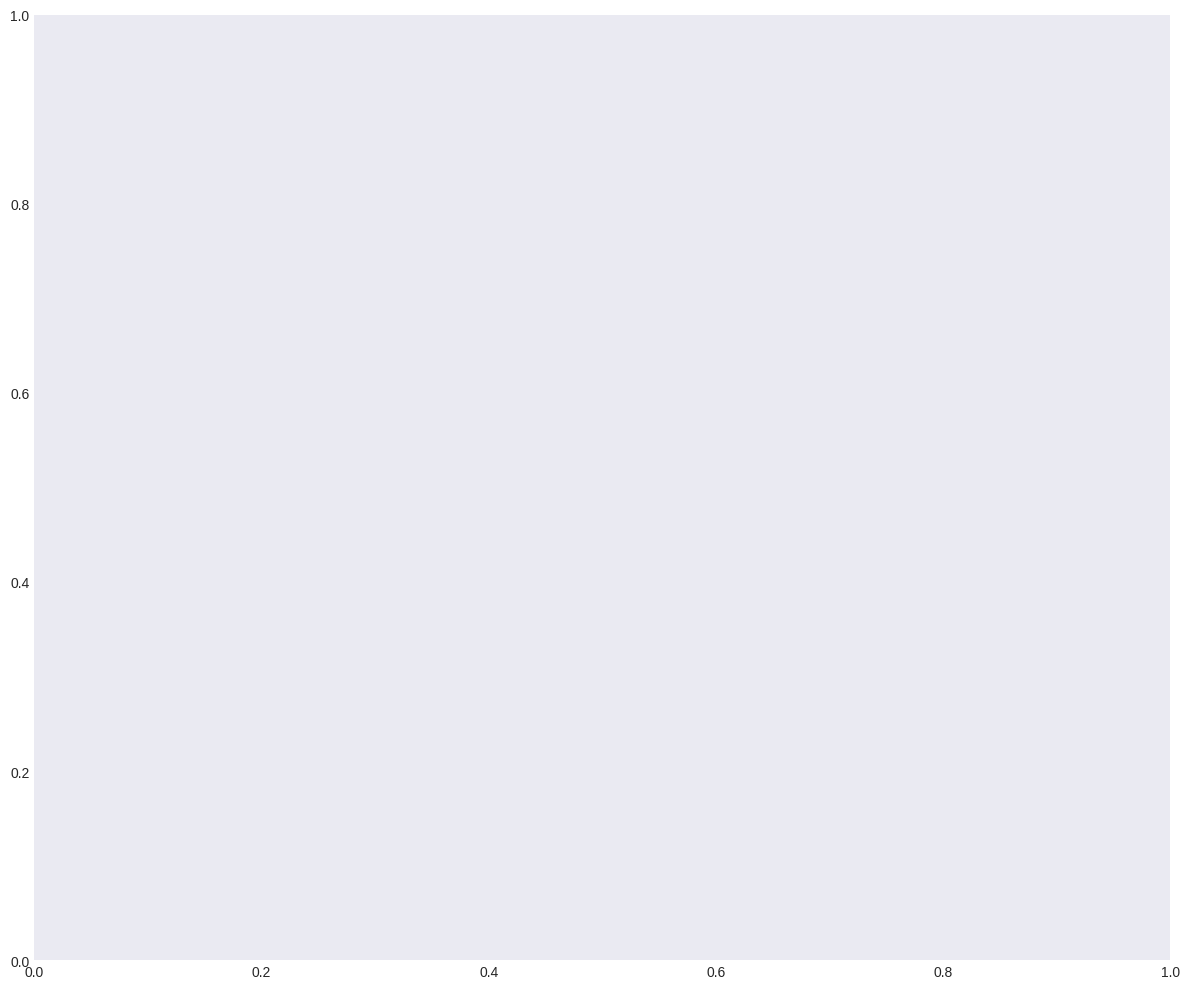

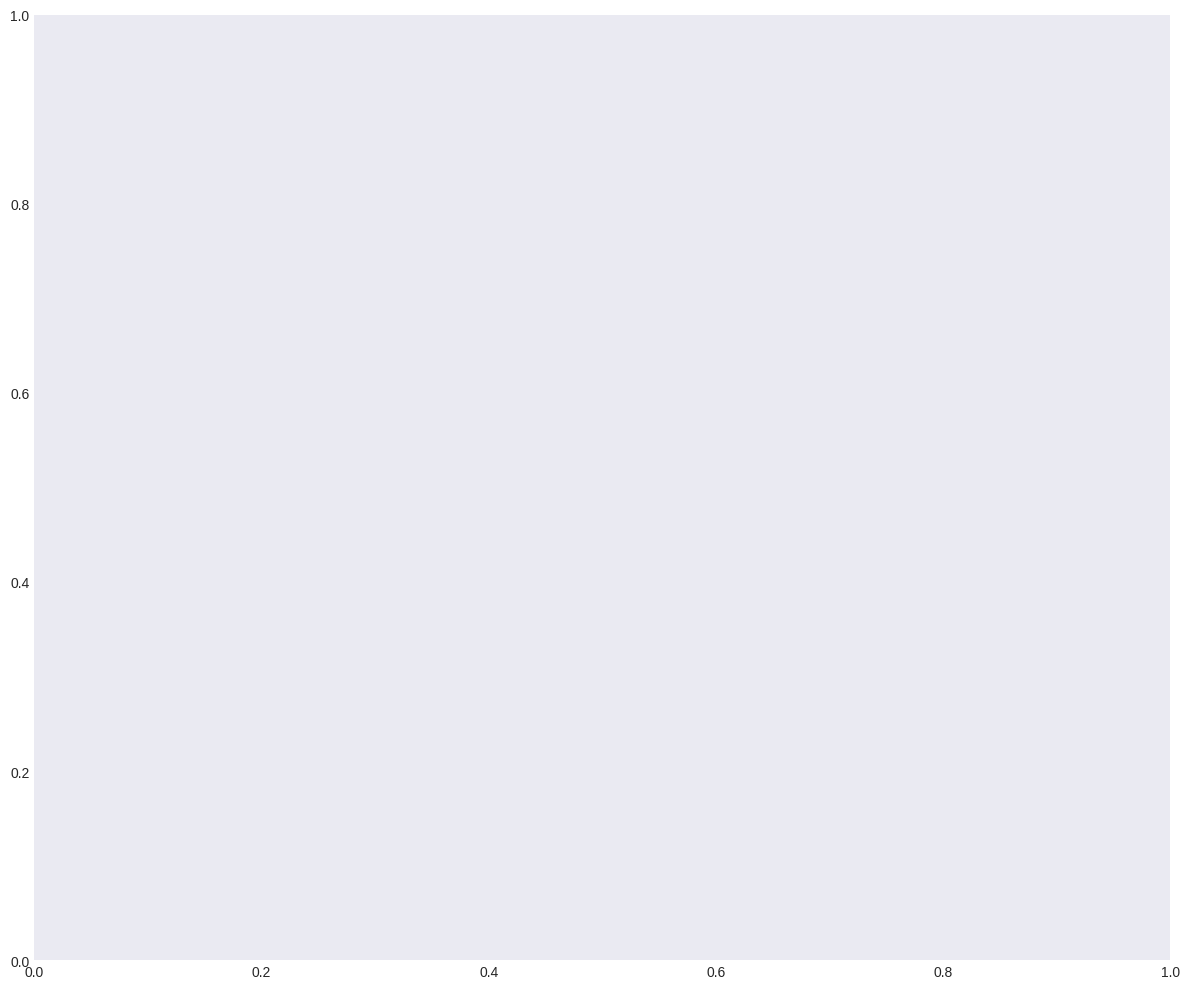

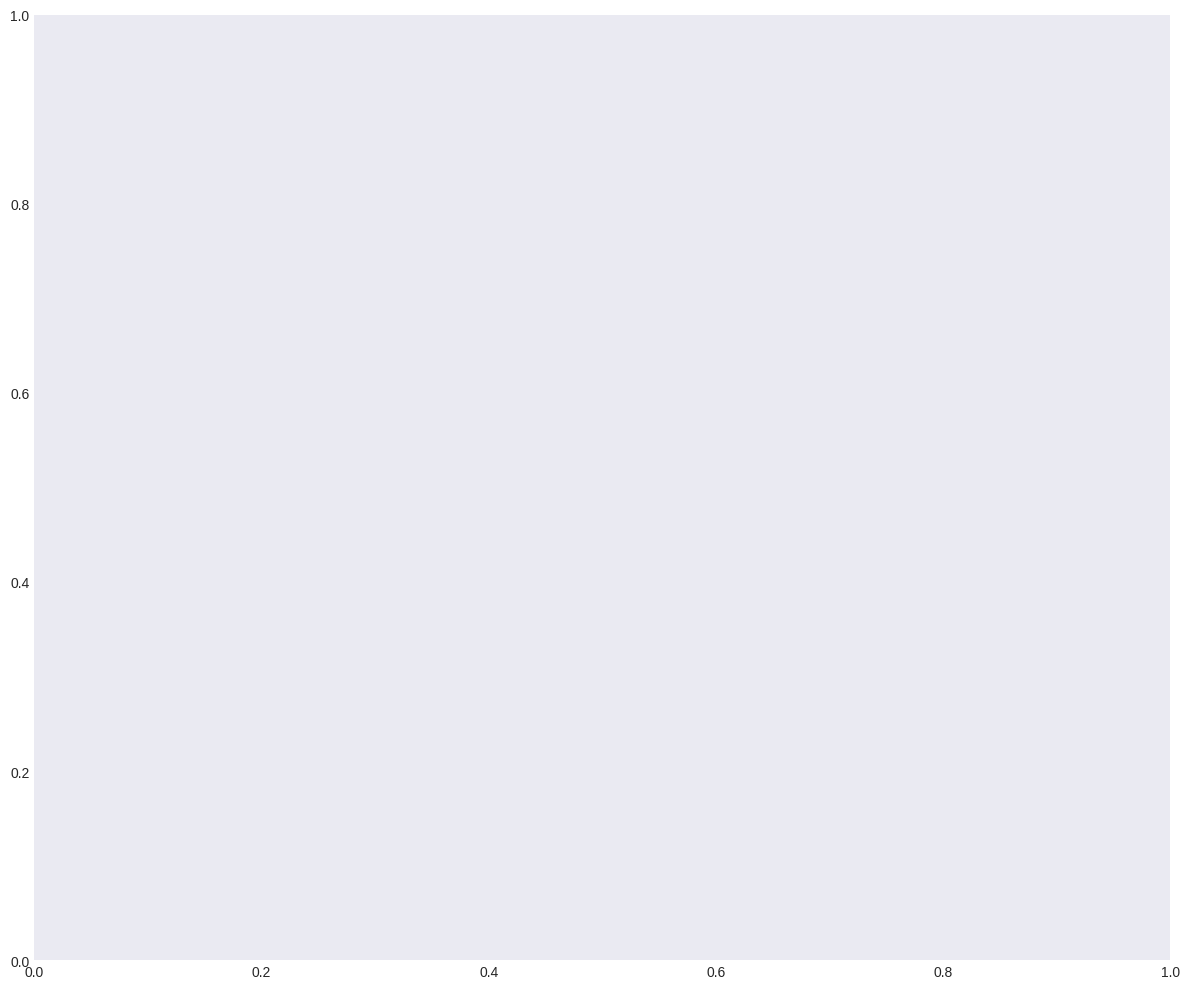

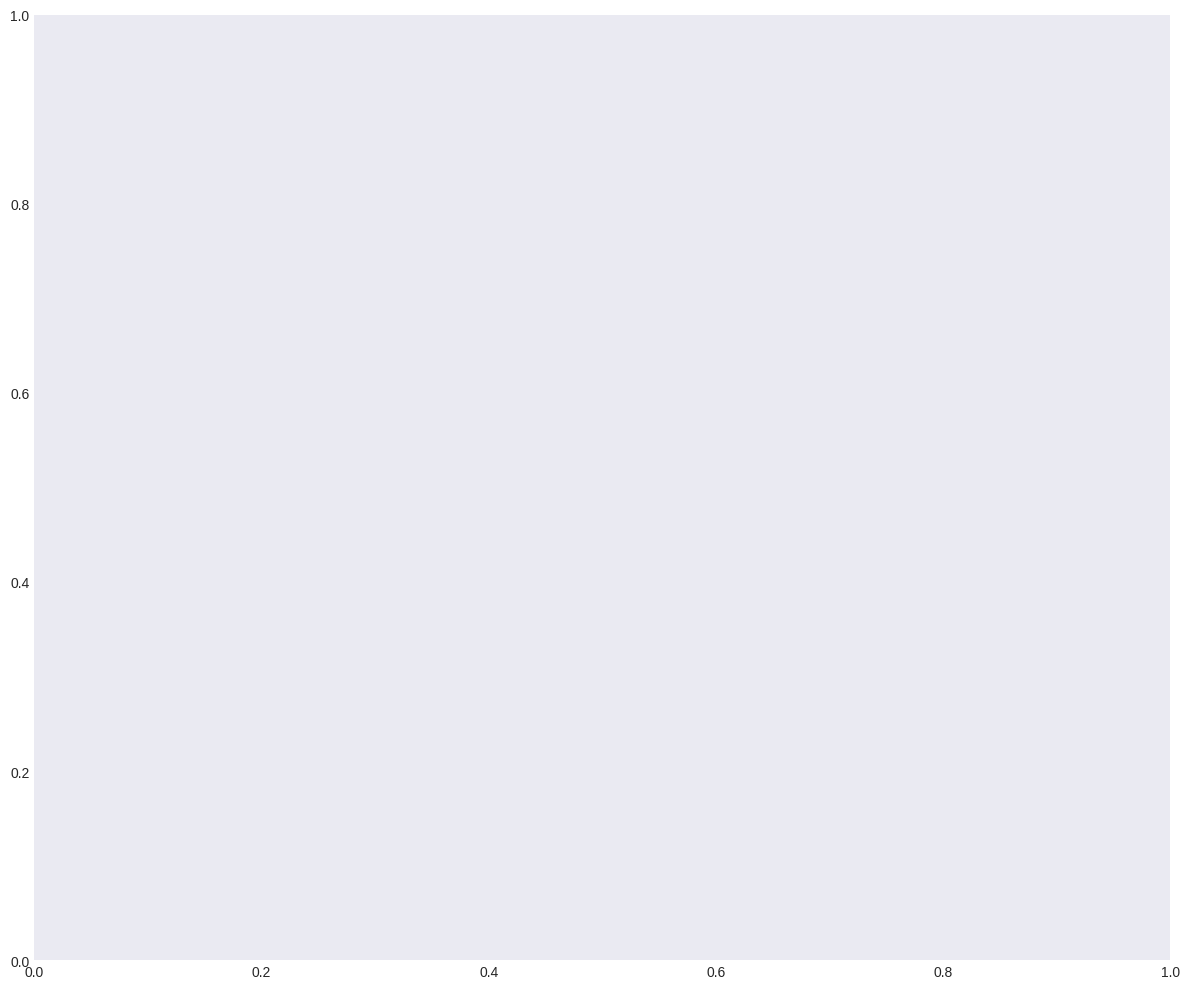

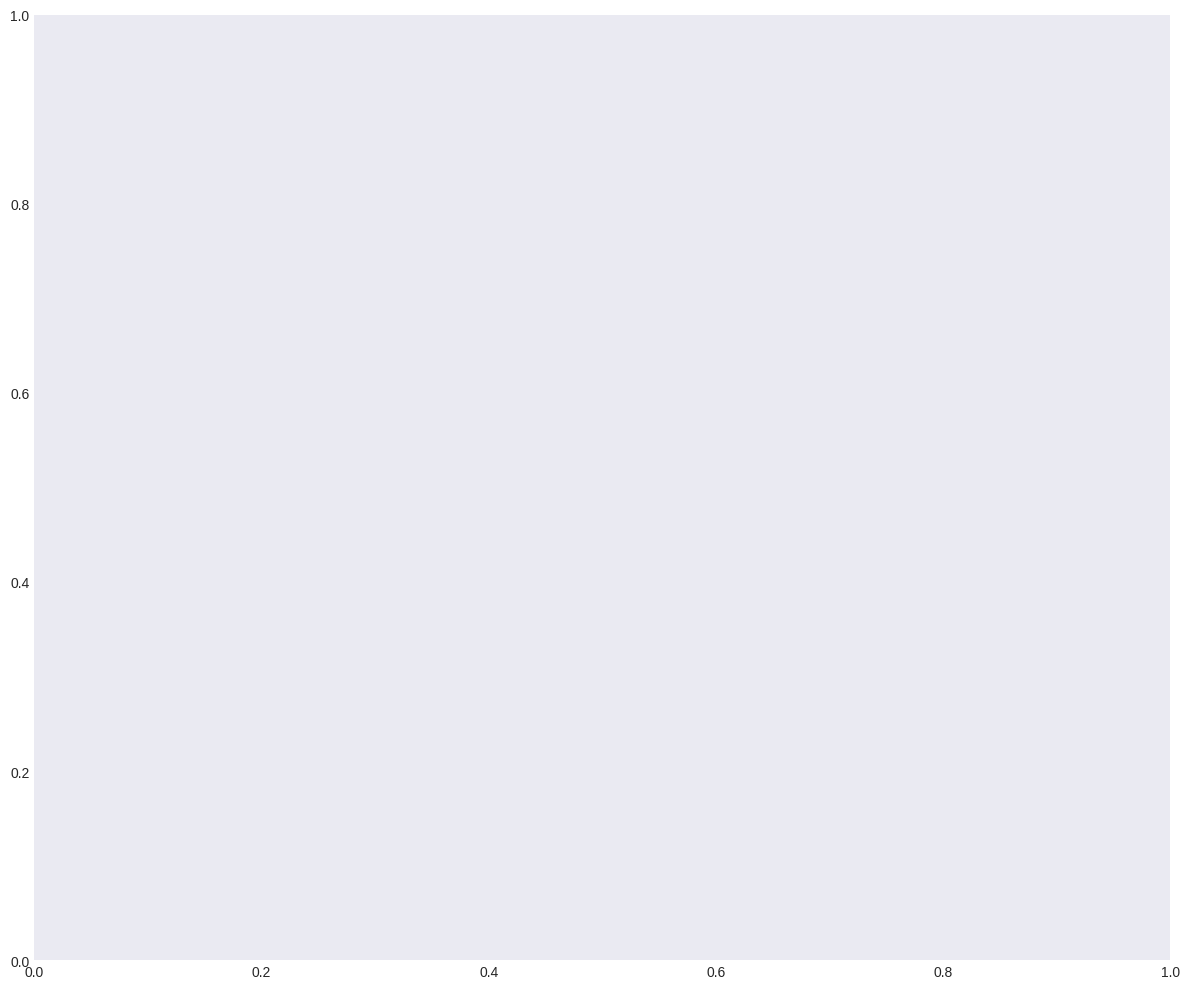

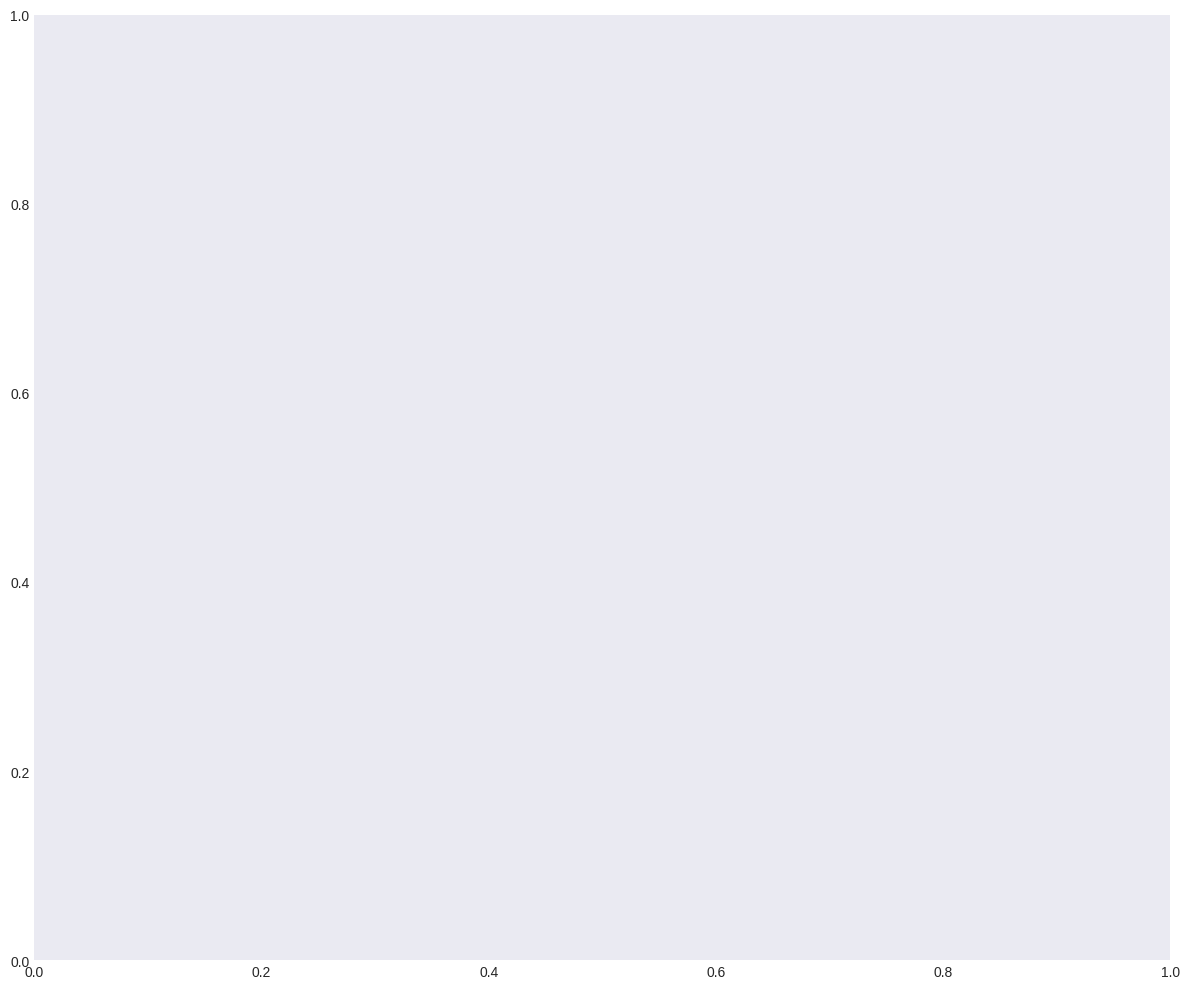

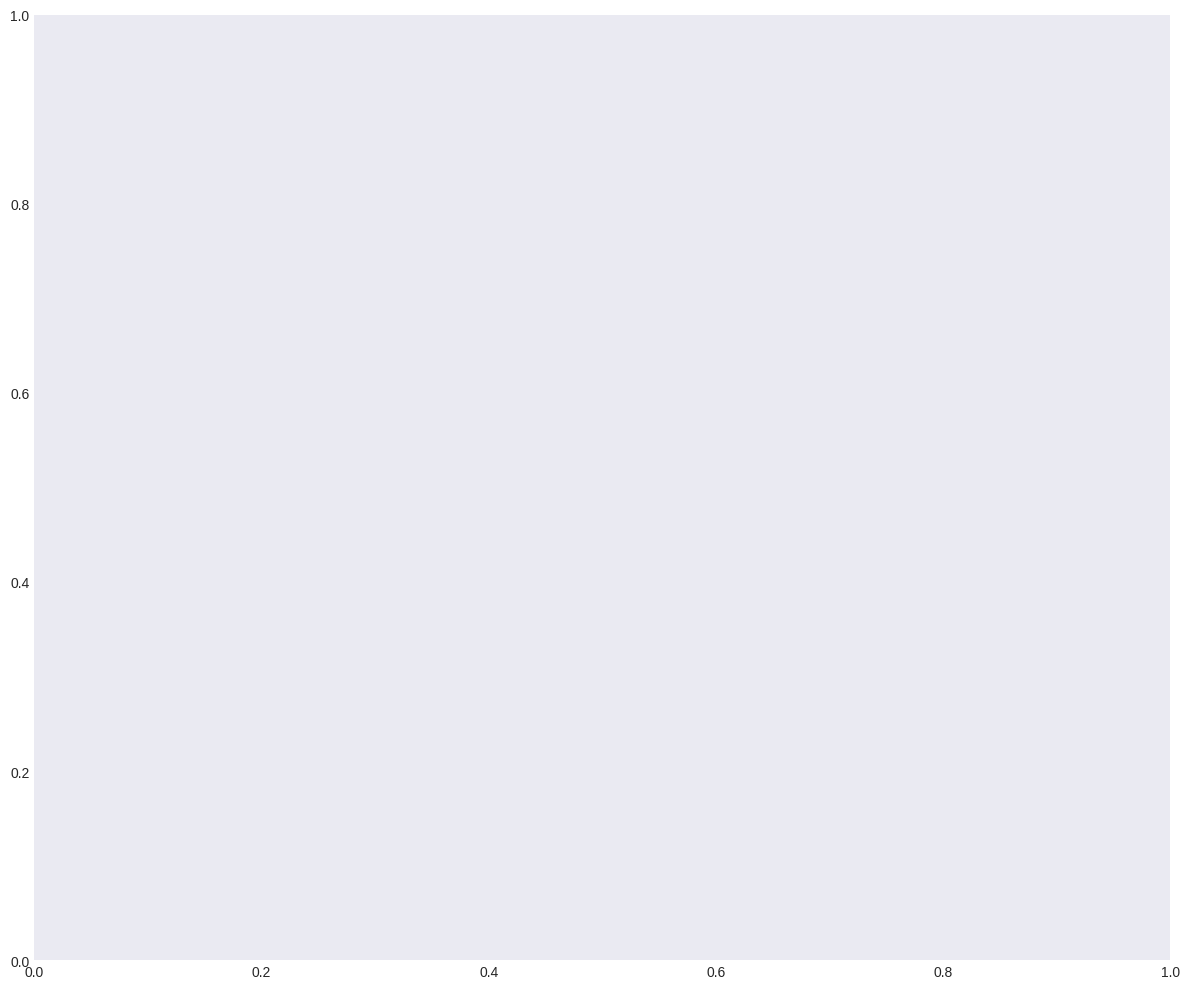

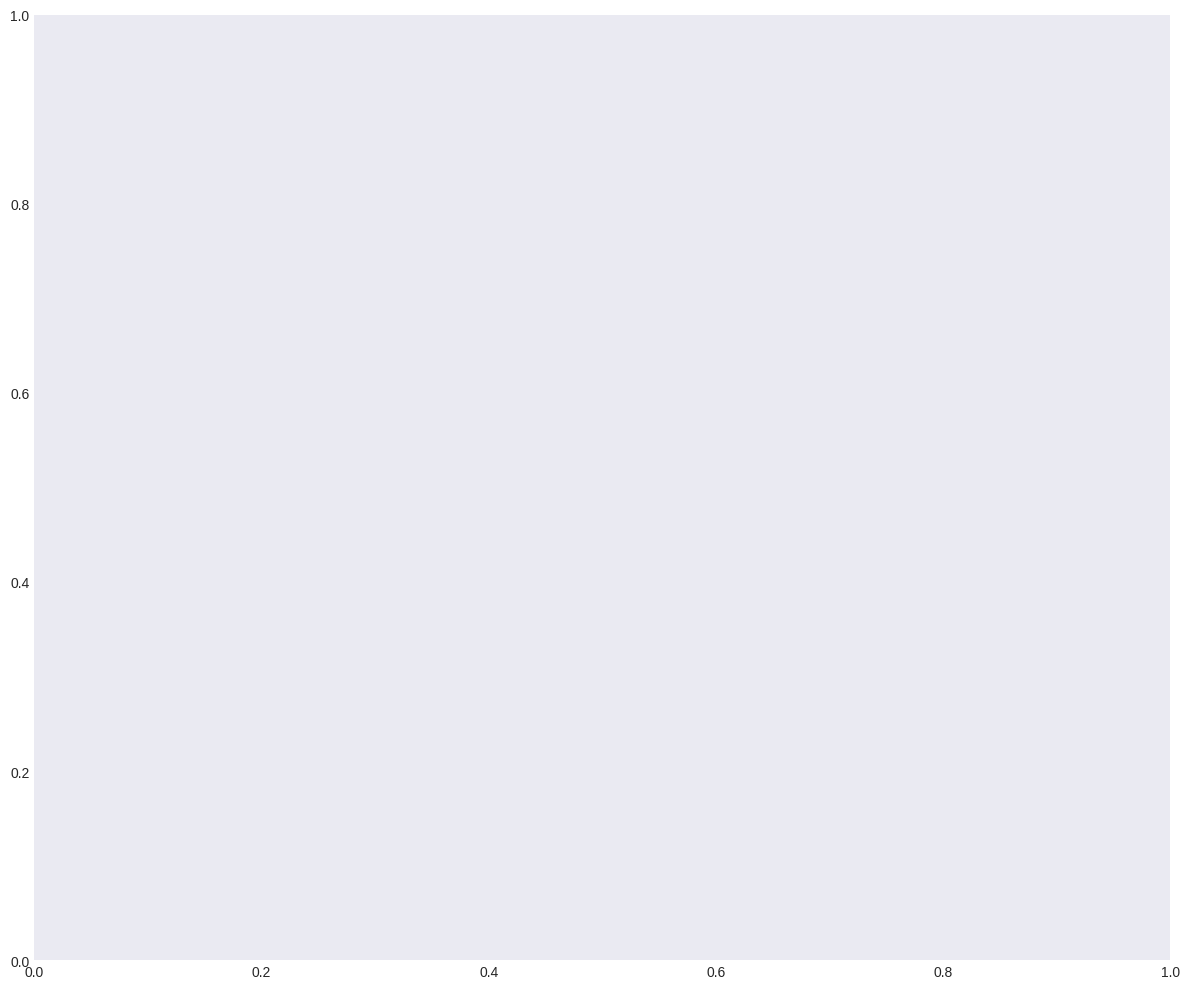

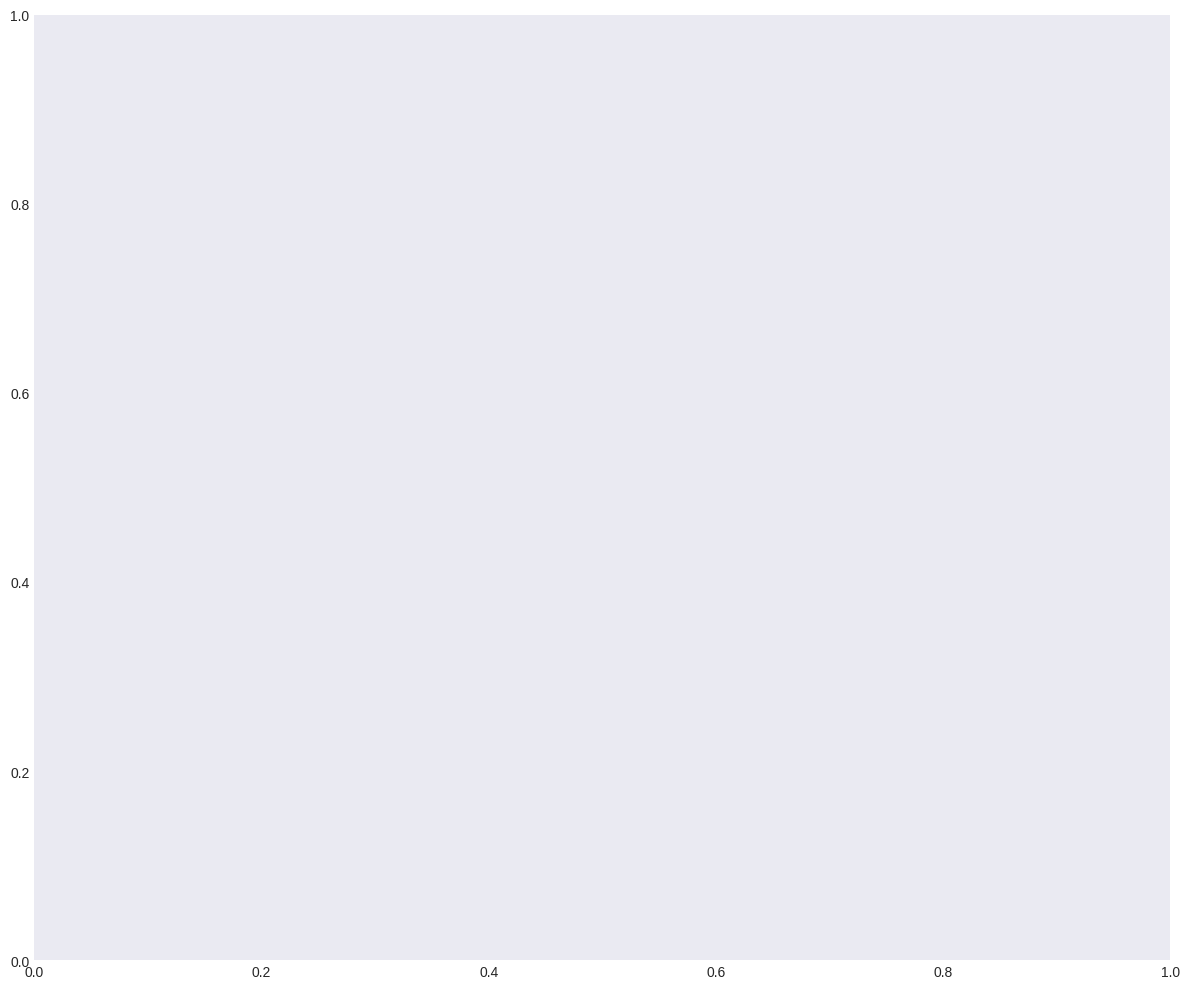

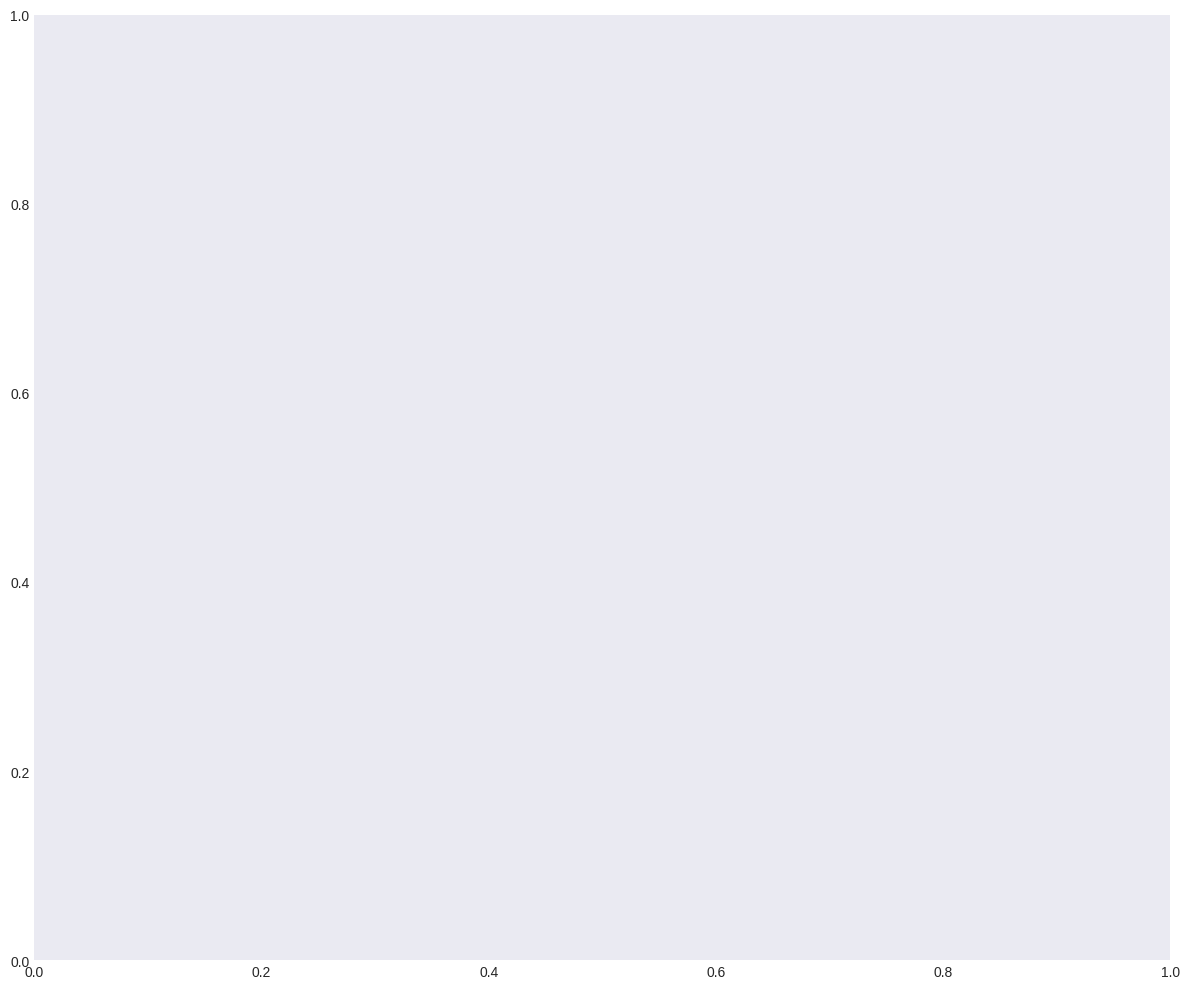

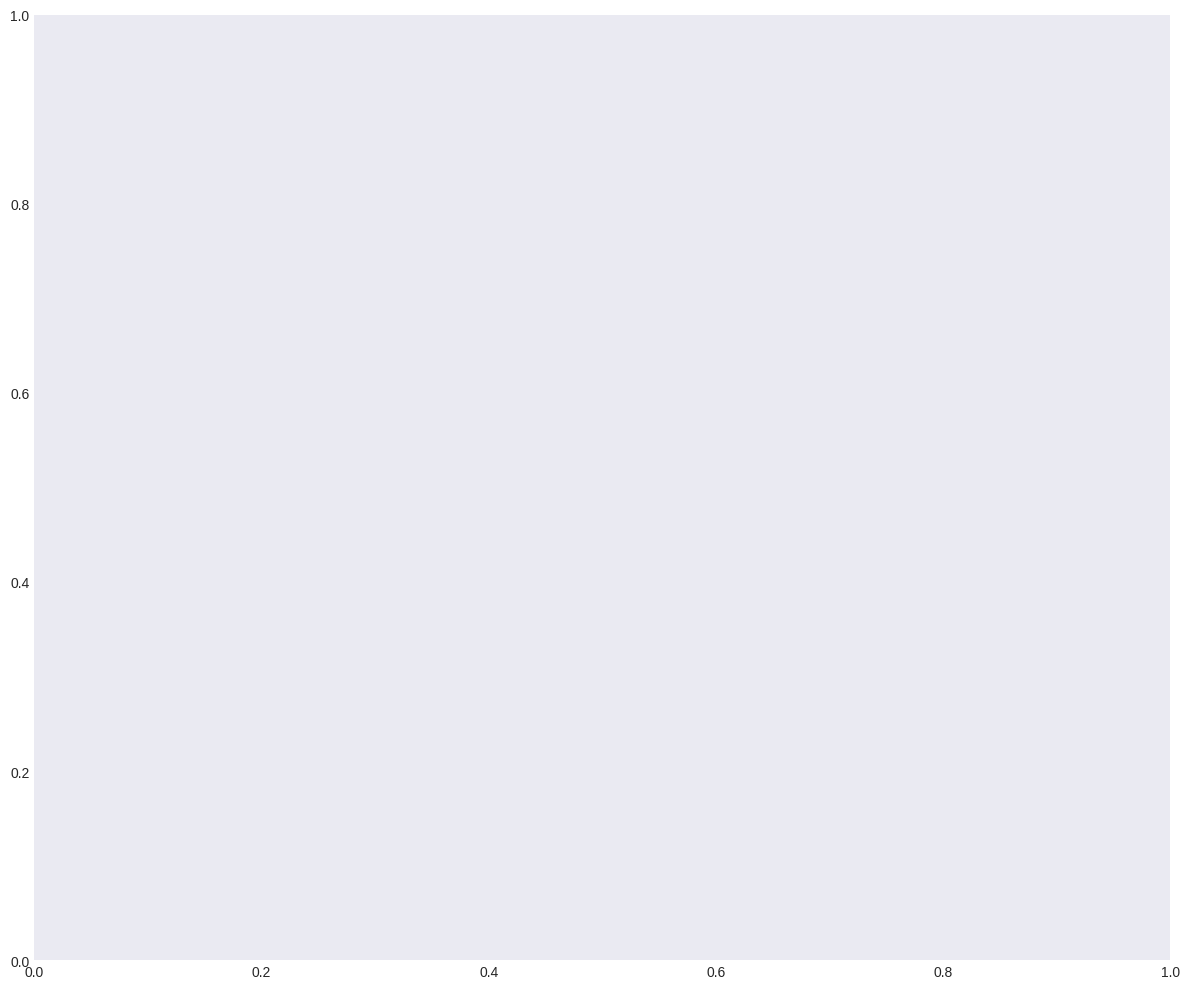

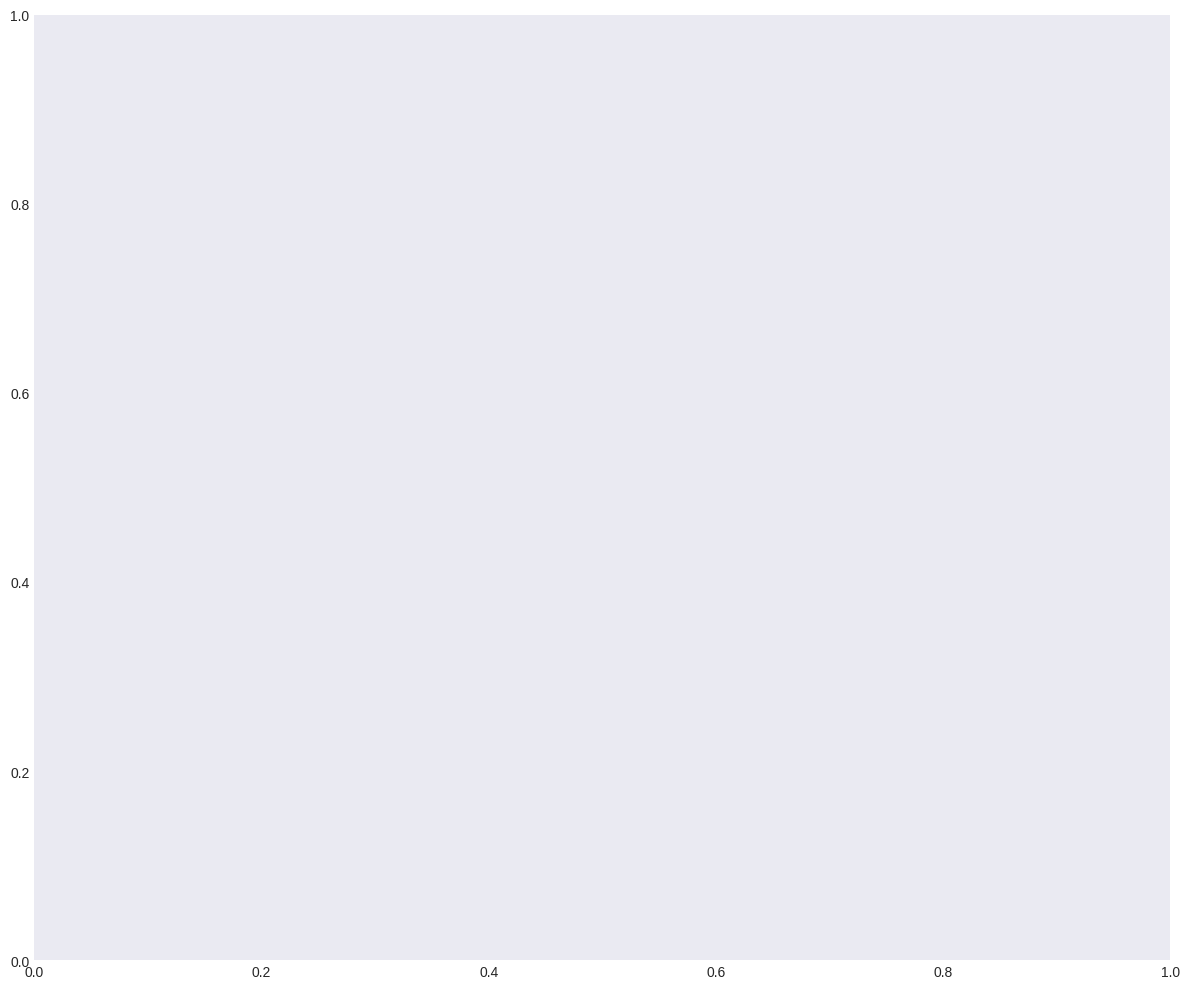

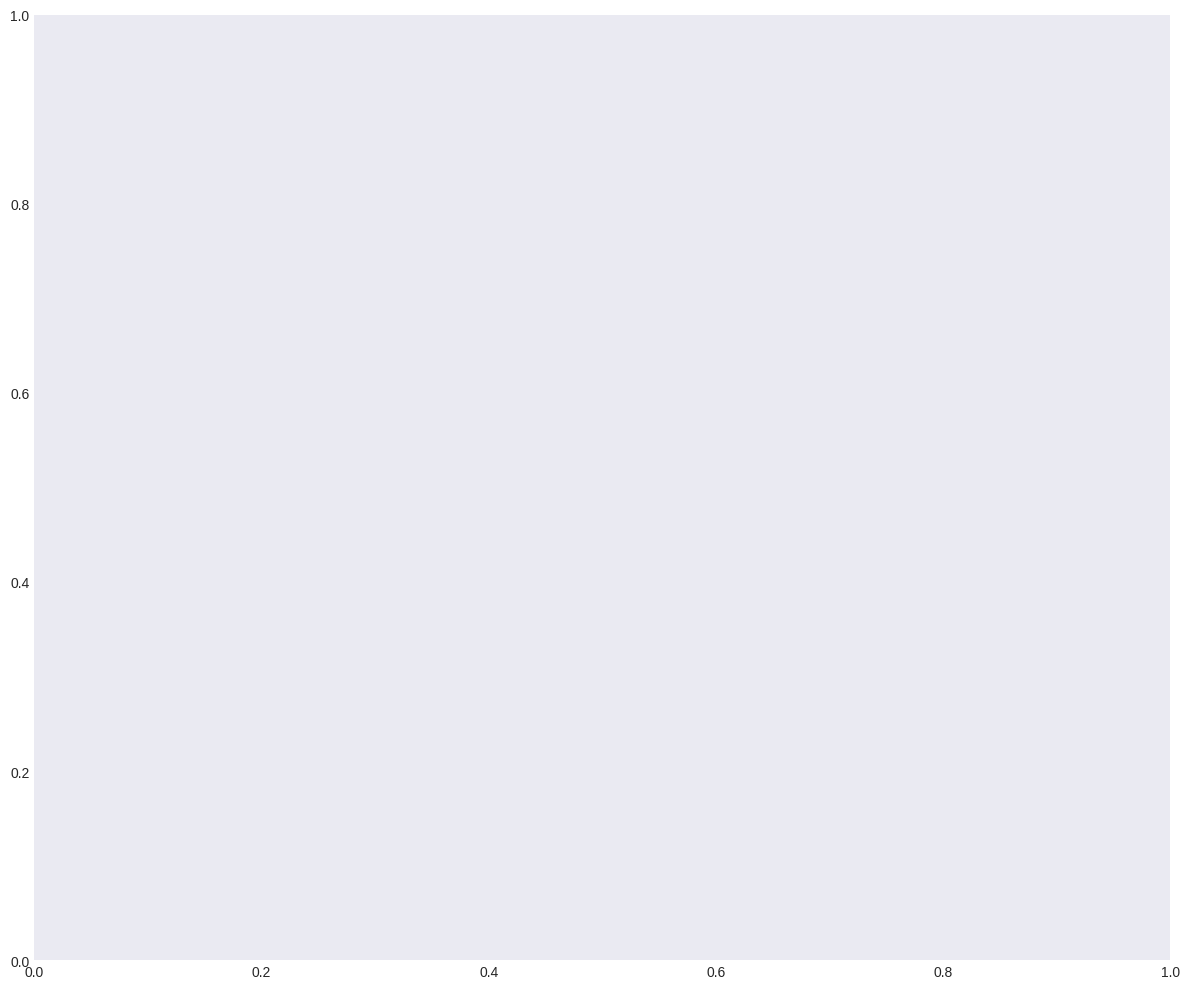

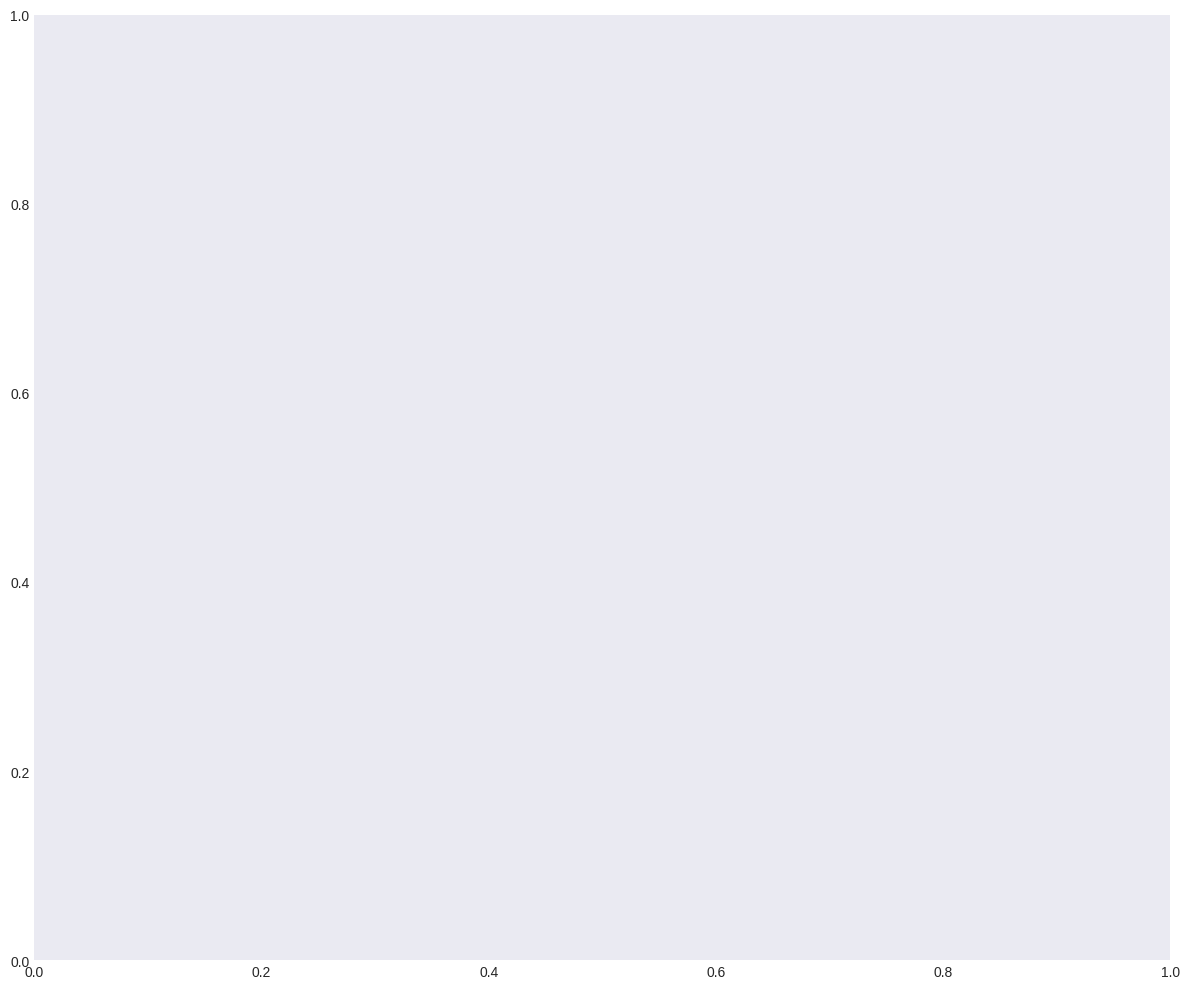

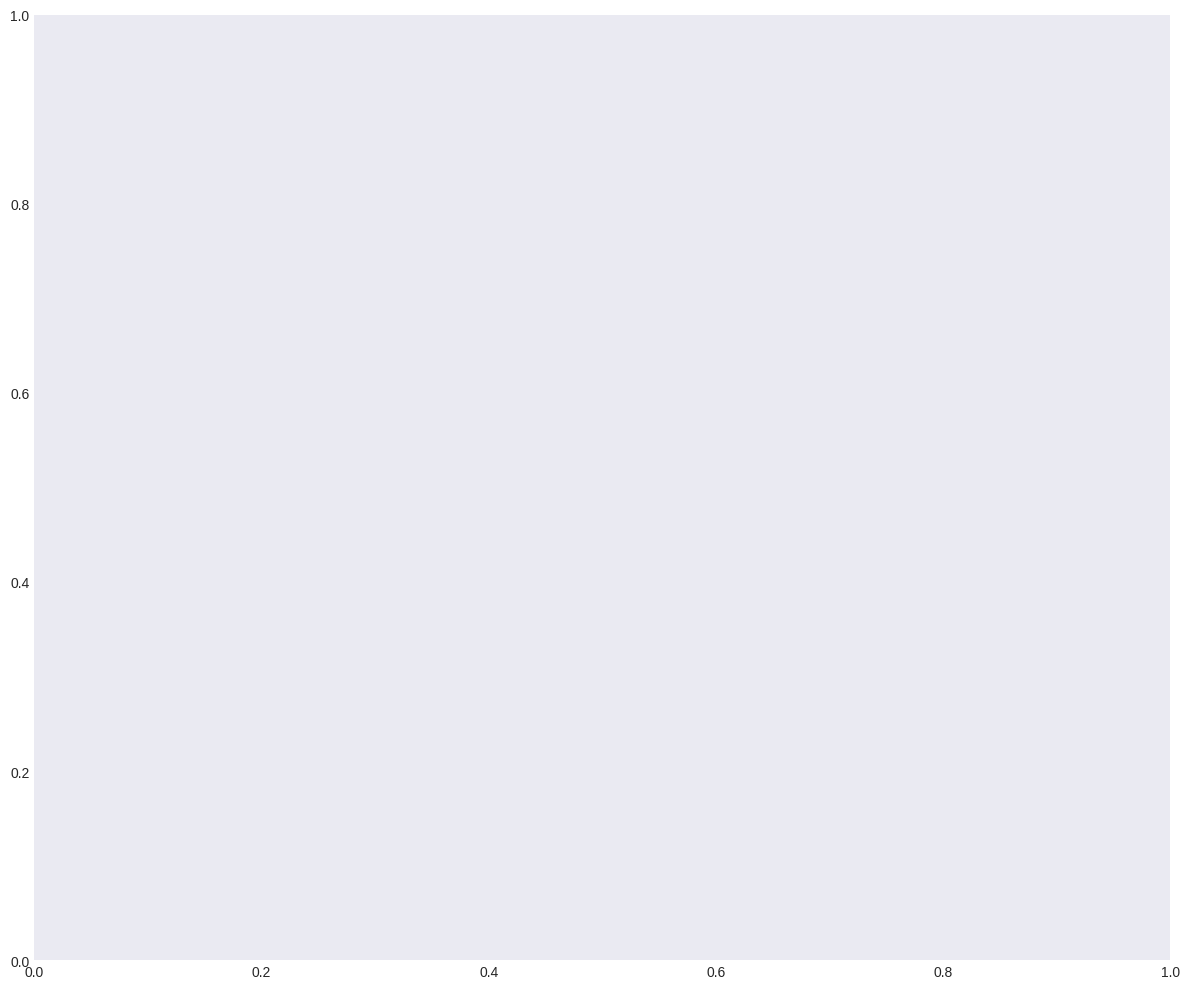

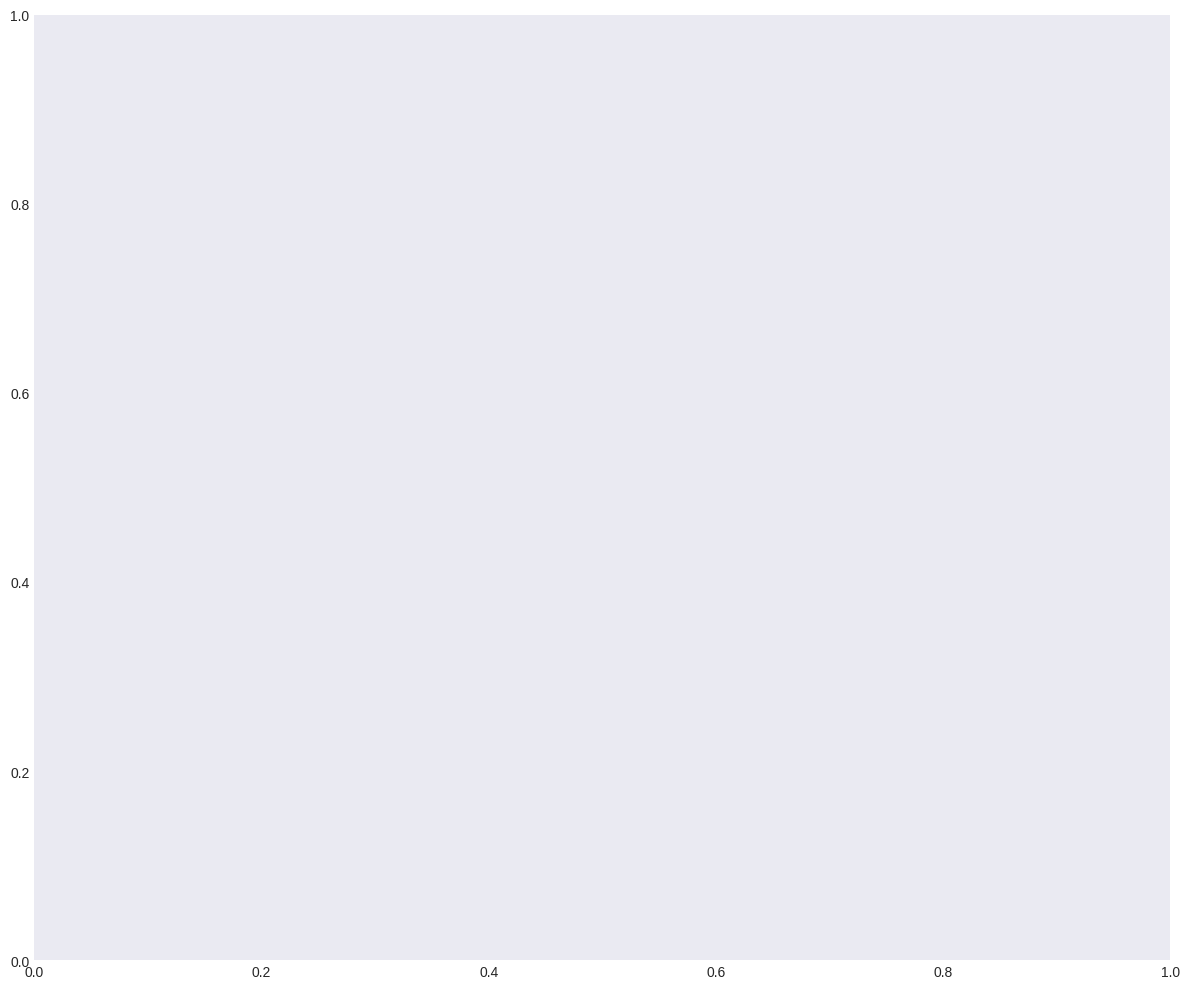

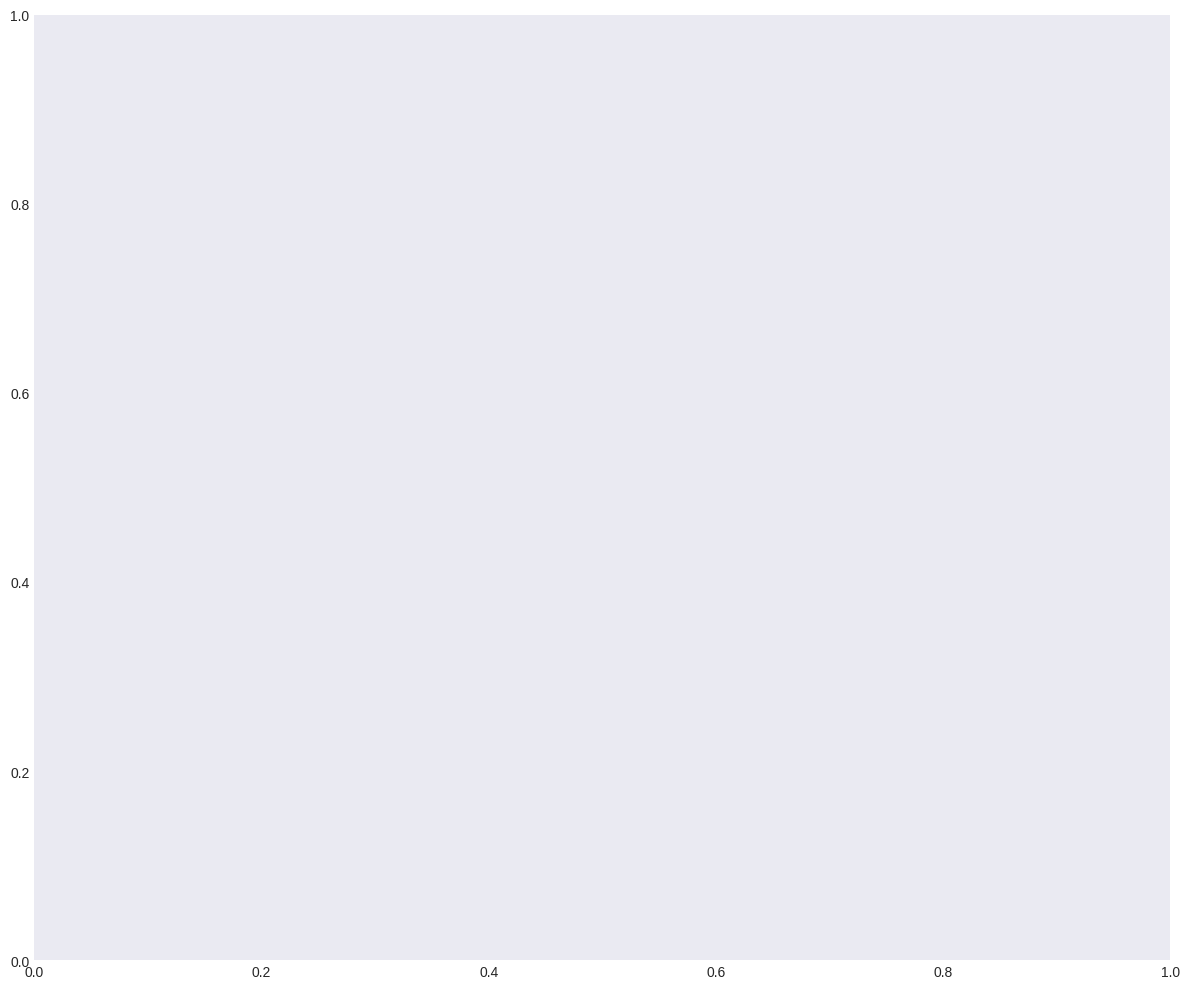

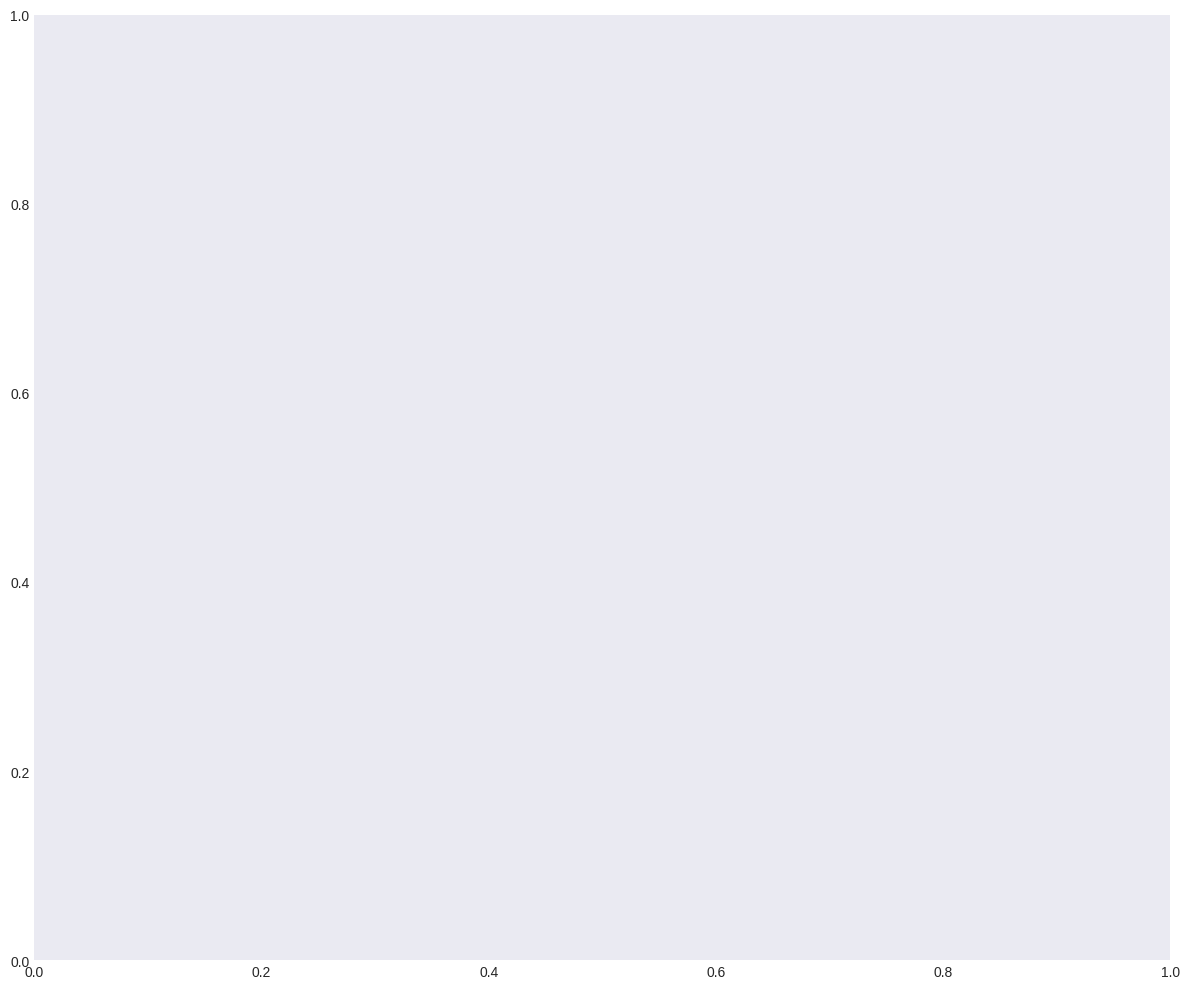

In [ ]:
def evaluate_model(
    model_name,
    assembly,
    test_loader,
    num_classes,
    device,
    model_path,
    results_path
):
    """Evaluates a trained model on test data."""
    # Load model
    if model_name == 'alexnet':
        model = models.alexnet(weights=None)
        # Get the number of classes from the saved model
        saved_state = torch.load(model_path)
        output_size = saved_state['classifier.6.bias'].size(0)
        model.classifier[6] = nn.Linear(4096, output_size)
    elif model_name == 'vgg16':
        model = models.vgg16(weights=None)
        saved_state = torch.load(model_path)
        output_size = saved_state['classifier.6.bias'].size(0)
        model.classifier[6] = nn.Linear(4096, output_size)
    elif model_name == 'resnet50':
        model = models.resnet50(weights=None)
        saved_state = torch.load(model_path)
        output_size = saved_state['fc.bias'].size(0)
        model.fc = nn.Linear(2048, output_size)

    # Load saved weights
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()

    # Get the original string labels
    label_to_idx = test_loader.dataset.label_to_idx
    class_names = list(label_to_idx.keys())

    print(f"Using class names for {assembly}: {class_names}")
    print(f"Label mapping: {label_to_idx}")
    print(f"Model output size: {output_size}")  # Debug print

    # Initialize metrics lists
    y_true = []
    y_pred = []
    y_prob = []
    inference_times = []

    # Evaluation loop
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc=f'Evaluating {model_name} on {assembly}')

        for images, labels in test_bar:
            images = images.to(device)
            labels = labels.to(device)

            # Measure inference time
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            outputs = model(images)
            end_time.record()

            torch.cuda.synchronize()
            inference_times.append(start_time.elapsed_time(end_time))

            _, predicted = torch.max(outputs, 1)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_prob.extend(probabilities.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    # Debug information
    print("\nPrediction Statistics:")
    print(f"Unique true labels: {np.unique(y_true)}")
    print(f"Unique predicted labels: {np.unique(y_pred)}")
    print(f"Probability shape: {y_prob.shape}")
    print("\nPrediction distribution:")
    for i, class_name in enumerate(class_names):
        n_true = np.sum(y_true == i)
        n_pred = np.sum(y_pred == i)
        print(f"{class_name}: {n_true} true, {n_pred} predicted")

    # Print sample probabilities
    print("\nSample probabilities for first few predictions:")
    for i in range(min(5, len(y_prob))):
        print(f"Sample {i}:")
        for j, class_name in enumerate(class_names):
            print(f"  {class_name}: {y_prob[i, j]:.4f}")

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Get ordered class names - 'good' first, then alphabetically
    class_names = ['good'] + sorted([name for name in label_to_idx.keys() if name != 'good'])

    # Create new label mapping based on our desired order
    new_label_to_idx = {name: idx for idx, name in enumerate(class_names)}

    # Reorder the confusion matrix
    n_classes = len(class_names)
    reordered_cm = np.zeros((n_classes, n_classes), dtype=int)

    for i, old_class_i in enumerate(class_names):
        for j, old_class_j in enumerate(class_names):
            old_idx_i = label_to_idx[old_class_i]
            old_idx_j = label_to_idx[old_class_j]
            reordered_cm[i, j] = cm[old_idx_i, old_idx_j]

    print(f"Original class order: {label_to_idx}")  # Debug print
    print(f"New class order: {new_label_to_idx}")   # Debug print

    plt.figure(figsize=(12, 10))
    ax = plt.gca()
    reordered_cm = reordered_cm[::-1, :]

    plt.figure(figsize=(12, 10))
    ax = plt.gca()

    sns.heatmap(
        reordered_cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        square=True,
        ax=ax,
        xticklabels=class_names,
        yticklabels=class_names[::-1],  # Reverse y-axis labels
        cbar=True
    )

    plt.title(f'Confusion Matrix - {model_name} ({assembly})', pad=20)
    plt.ylabel('True Label', labelpad=10)
    plt.xlabel('Predicted Label', labelpad=10)

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.tight_layout()

    plt.savefig(
        os.path.join(results_path, f'{model_name}_{assembly}_confusion_matrix.png'),
        bbox_inches='tight',
        pad_inches=0.5
    )
    plt.close()

    # ROC curves with fixed calculation
    plt.figure(figsize=(12, 8))

    # Calculate ROC curves for each class using one-vs-rest approach
    for i, class_name in enumerate(class_names):
        # Create binary labels for current class
        binary_y_true = (y_true == i).astype(int)

        # Get probabilities for current class
        binary_y_score = y_prob[:, i]

        # Only calculate ROC if we have samples from both classes
        if np.sum(binary_y_true) > 0 and np.sum(binary_y_true) < len(binary_y_true):
            fpr, tpr, _ = roc_curve(binary_y_true, binary_y_score)
            roc_auc = auc(fpr, tpr)
            plt.plot(
                fpr,
                tpr,
                label=f'{class_name} (AUC = {roc_auc:.4f})'
            )
            print(f"Class {class_name}: AUC = {roc_auc:.4f}")  # Debug print
        else:
            print(f"Warning: Skipping ROC curve for class {class_name} due to insufficient samples")
            print(f"Class distribution: {np.bincount(binary_y_true)}")  # Debug print

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {model_name} ({assembly})')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(results_path, f'{model_name}_{assembly}_roc_auc.png'))
    plt.close()

    # Calculate metrics
    accuracy = np.mean(y_true == y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )
    avg_inference_time = np.mean(inference_times)
    confidence = np.mean(np.max(y_prob, axis=1))

    metrics = {
        'accuracy': round(accuracy, 4),
        'precision': round(precision, 4),
        'recall': round(recall, 4),
        'f1_score': round(f1, 4),
        'avg_inference_time_ms': round(avg_inference_time, 4),
        'confidence': round(confidence, 4)
    }

    return metrics

# Create results directory
results_dir = os.path.join(base_path, 'results')
os.makedirs(results_dir, exist_ok=True)

# Evaluate each model
architectures = ['alexnet', 'vgg16', 'resnet50']
all_metrics = {}

for arch in architectures:
    print(f'\nEvaluating {arch}...')

    # Create model-specific results directory
    model_results_dir = os.path.join(results_dir, arch)
    os.makedirs(model_results_dir, exist_ok=True)

    model_metrics = []

    # Evaluate on each assembly
    for assembly in dataset_info:
        print(f'\nEvaluating {arch} on {assembly}...')

        # Get unique labels
        unique_labels = sorted(set(
        dataset_info[assembly]['test_labels']  # Only use test labels since that's what we're evaluating
        ))
        label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

        print(f"Classes in test data for {assembly}: {unique_labels}")

        print(f"Actual class names for {assembly}: {unique_labels}")  # Debug print

        # Setup test dataset with string labels
        test_dataset = AutoVIDataset(
            dataset_info[assembly]['test_paths'],
            dataset_info[assembly]['test_labels'],  # Pass original string labels
            transform=transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
            preprocess=ImagePreprocessor().preprocess
        )

        # Keep track of original labels
        test_dataset.original_labels = unique_labels

        # Create test loader
        test_loader = DataLoader(
            test_dataset,
            batch_size=32,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )

        # Evaluate model
        metrics = evaluate_model(
            arch,
            assembly,
            test_loader,
            len(unique_labels),
            device,
            os.path.join(base_path, 'models', assembly, f'{arch}.pth'),
            model_results_dir
        )

        # Add assembly name to metrics
        metrics['assembly'] = assembly
        model_metrics.append(metrics)

    # Save metrics to CSV
    metrics_df = pd.DataFrame(model_metrics)
    metrics_df.to_csv(
        os.path.join(model_results_dir, f'{arch}_{assembly}_metrics.csv'),
        index=False
    )
    all_metrics[arch] = metrics_df

print('\nEvaluation completed for all models!')